In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate, optimize
import ddm
import ddm.plot
import os 
import paranoid as pns
pns.settings.Settings.set(enabled=False)

# Loss function definitions

In [2]:
class LossByMeans(ddm.LossFunction):
    # This is a shortcut loss function for optimizing fit to accuracy and mean RT, as opposed to full RT distribution
    name = 'Mean correct RT and accuracy'
    def setup(self, dt, T_dur, **kwargs):
        self.dt = dt
        self.T_dur = T_dur
        self.exp_data = pd.read_csv('measures.csv', usecols=['RT', 'is_turn_decision', 'tta_condition'])
        
    def loss(self, model):
        sols = self.cache_by_conditions(model)
        MSE = 0
        for comb in self.sample.condition_combinations(required_conditions=self.required_conditions):
            c = frozenset(comb.items())
            mean_rt_exp_cor = self.exp_data[(self.exp_data.tta_condition == comb['tta_condition']) & 
                                            self.exp_data.is_turn_decision == True].RT.mean()
            comb_sample = self.sample.subset(**comb)
            MSE += (sols[c].prob_correct() - comb_sample.prob_correct())**2
            if sols[c].prob_correct() > 0:
                MSE += (sols[c].mean_decision_time() - mean_rt_exp_cor)**2
        return MSE
    
class LossWLS(ddm.LossFunction):
    name = 'Weighted least squares as described in Ratcliff & Tuerlinckx 2002'
    rt_quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
    rt_q_weights = [2, 2, 1, 1, 0.5]
    
    def setup(self, dt, T_dur, **kwargs):
        self.dt = dt
        self.T_dur = T_dur
    
    def get_rt_quantiles(self, x, t_domain, exp=False):
        cdf = x.cdf_corr(T_dur=self.T_dur, dt=self.dt) if exp else x.cdf_corr()
        cdf_interp = interpolate.interp1d(t_domain, cdf/cdf[-1])
        rt_quantile_values = [optimize.root_scalar(lambda x:cdf_interp(x)-quantile, bracket=(0, t_domain[-1])).root
                              for quantile in self.rt_quantiles]
        return np.array(rt_quantile_values)
    
    def loss(self, model):
        solultions = self.cache_by_conditions(model)
        WLS = 0
        for comb in self.sample.condition_combinations(required_conditions=self.required_conditions):
            c = frozenset(comb.items())
            comb_sample = self.sample.subset(**comb)
            WLS += 4*(solultions[c].prob_correct() - comb_sample.prob_correct())**2
            if solultions[c].prob_correct() > 0:
                model_rt_q = self.get_rt_quantiles(solultions[c], model.t_domain(), exp=False)
                exp_rt_q = self.get_rt_quantiles(comb_sample, model.t_domain(), exp=True)
                # this can be modified from R&T 2002: *comb_sample.prob_correct() can be removed to improve RT fit at low-p trials
                WLS += np.dot((model_rt_q-exp_rt_q)**2, self.rt_q_weights)*comb_sample.prob_correct()
        return WLS

# Helper functions

In [3]:
def get_model_measures(model, tta_condition):
    sol = model.solve(conditions={'tta_condition': tta_condition})
    return tta_condition, sol.prob_correct(), sol.mean_decision_time()
        
def save_fitting_results(exp_data, fit_model):
    print('Loss function value: %.5f' % (fit_model.get_fit_result().value()))
    print('Parameters: ', fit_model.get_model_parameters())
    
    directory = 'model_fit_results/%s' % (fit_model.name.lower().replace(' ', '_'))
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    model_measures = [get_model_measures(fit_model, tta_condition) for tta_condition in exp_data.tta_condition.unique()]
    model_measures = pd.DataFrame(model_measures, columns=['tta_condition', 'is_turn_decision', 'RT'])
    model_measures['loss'] = fit_model.get_fit_result().value()    
    model_measures.to_csv(os.path.join(directory, 'measures.csv'), index=False)
    
    rt_dfs = []
    for i, tta_condition in enumerate(exp_data.tta_condition.unique()):
        sol = fit_model.solve(conditions={'tta_condition': tta_condition})
        rt_df = pd.DataFrame({'condition': tta_condition,
                              't': fit_model.t_domain(),
                              'rt_corr_pdf': sol.pdf_corr()/sol.prob_correct()})
        rt_dfs.append(rt_df)
    rt_dfs = pd.concat(rt_dfs)
    rt_dfs.to_csv(os.path.join(directory, 'rt_pdf.csv'), index=False)

# Model definitions

Duration of model simulations is set to 2.5 (upper boundary on experimentally observed response times)

In [4]:
T_dur = 2.5

### Model 1. DDM with TTA-dependent drift 

In [5]:
class DriftTta(ddm.models.Drift):
    name = 'Drift depends on TTA'
    required_parameters = ['alpha', 'tta_crit']
    required_conditions = ['tta_condition'] 
    
    def get_drift(self, t, conditions, **kwargs):
        return self.alpha*(conditions['tta_condition'] - t - self.tta_crit)

In [6]:
model_tta_dependent_drift = ddm.Model(name='1 TTA-dependent drift',
                                      drift=DriftTta(alpha=ddm.Fittable(minval=0.1, maxval=3),
                                                     tta_crit=ddm.Fittable(minval=3, maxval=6)),
                                      noise=ddm.NoiseConstant(noise=1),
                                      bound=ddm.BoundConstant(B=ddm.Fittable(minval=.1, maxval=3.0)),
                                      T_dur=T_dur)

### Model 2. Model 1 + nondecision time

In [7]:
model_nondecision_time_fixed = ddm.Model(name='2 TTA-dependent drift and fixed nondecision time',
                                      drift=DriftTta(alpha=ddm.Fittable(minval=0.1, maxval=3),
                                                     tta_crit=ddm.Fittable(minval=3, maxval=6)),
                                      noise=ddm.NoiseConstant(noise=1),
                                      bound=ddm.BoundConstant(B=ddm.Fittable(minval=.1, maxval=3.0)),
                                      overlay=ddm.OverlayNonDecision(nondectime=ddm.Fittable(minval=0, maxval=0.5)),
                                      T_dur=T_dur)

### Model 3. Model 2 + nondecision time variability

In [8]:
model_nondecision_time_variable = ddm.Model(name='3 TTA-dependent drift and uniformly distributed nondecision time',
                                     drift=DriftTta(alpha=ddm.Fittable(minval=0.1, maxval=3),
                                                    tta_crit=ddm.Fittable(minval=3, maxval=6)),
                                     noise=ddm.NoiseConstant(noise=1),
                                     bound=ddm.BoundConstant(B=ddm.Fittable(minval=.1, maxval=3.0)),
                                     overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0, maxval=0.5),
                                                                           halfwidth=ddm.Fittable(minval=0, maxval=0.3)),
                                     T_dur=T_dur)

### Model 4. Model 3 + collapsing bounds

In [9]:
model_collapsing_bounds = ddm.Model(name='''4 TTA-dependent drift and uniformly distributed nondecision time 
                                    and exponentially collapsing bounds''',
                                    drift=DriftTta(alpha=ddm.Fittable(minval=0.1, maxval=3), 
                                                   tta_crit=ddm.Fittable(minval=3, maxval=6)),
                                    noise=ddm.NoiseConstant(noise=1),
                                    bound=ddm.BoundCollapsingExponential(B=ddm.Fittable(minval=0.5, maxval=5), 
                                                                         tau=ddm.Fittable(minval=0.5, maxval=5)),
                                    overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0, maxval=0.5),
                                                                          halfwidth=ddm.Fittable(minval=0, maxval=0.3)),
                                    T_dur=T_dur)

### Model 5. Model 3 + TTA-dependent bounds

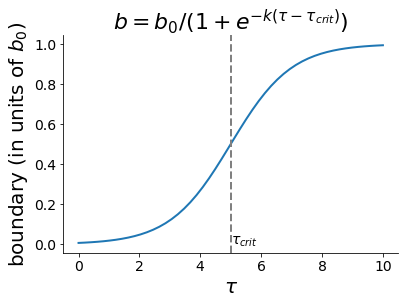

In [10]:
b_0 = 1
k = 1
tta_crit = 5
tau = np.linspace(0, 10)
b = lambda tau: b_0/(1+np.exp(-k*(tau-tta_crit)))

fig, ax = plt.subplots()
ax.plot(tau, b(tau))
ax.axvline(tta_crit, color='grey', ls='--')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('boundary (in units of $b_0$)')
# ax.legend(loc='lower right')
ax.set_title(r'$b = b_0/(1+e^{-k(\tau-\tau_{crit})})$')
ax.text(x=tta_crit, y=0, s=r'$\tau_{crit}$', fontsize=14);

In [11]:
class BoundCollapsingTta(ddm.models.Bound):
    name = 'Bounds collapsing with TTA'
    required_parameters = ['b_0', 'k', 'tta_crit']
    required_conditions = ['tta_condition'] 
    def get_bound(self, t, conditions, **kwargs):
        tau = conditions['tta_condition'] - t
        return self.b_0/(1+np.exp(-self.k*(tau-self.tta_crit)))

tta_crit = ddm.Fittable(minval=3, maxval=6)
    
model_TTA_bounds = ddm.Model(name='5 TTA-dependent drift and bounds and uniformly distributed nondecision time',
                             drift=DriftTta(alpha=ddm.Fittable(minval=0.1, maxval=5), 
                                            tta_crit=tta_crit),
                             noise=ddm.NoiseConstant(noise=1),
                             bound=BoundCollapsingTta(b_0=ddm.Fittable(minval=0.5, maxval=5), 
                                                      k=ddm.Fittable(minval=0.1, maxval=2),
                                                      tta_crit=tta_crit),
                             overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0, maxval=0.5),
                                                                   halfwidth=ddm.Fittable(minval=0, maxval=0.3)),
                             T_dur=T_dur)

# Model fitting

Reading experimental data

In [12]:
exp_data = pd.read_csv('measures.csv', usecols=['RT', 'is_turn_decision', 'tta_condition'])
exp_sample = ddm.Sample.from_pandas_dataframe(df=exp_data, rt_column_name='RT', correct_column_name='is_turn_decision')

models = [model_tta_dependent_drift, 
          model_nondecision_time_fixed, 
          model_nondecision_time_variable,
          model_collapsing_bounds, 
          model_TTA_bounds]

In [ ]:
fit_models = []
for model in models:
    print(model.name)
    fit_model = ddm.fit_adjust_model(sample=exp_sample, model=model, lossfunction=LossWLS)
    save_fitting_results(exp_data, fit_model)
    fit_models.append(fit_model)

1 TTA-dependent drift
[2.427034769221619, 4.064955264021557, 0.7573949514657976]
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(1.4685689679365013, minval=0.1, maxval=3), tta_crit=Fitted(3.9405807425215746, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.5035095376609988, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7491000233873039
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(2.647897836961202, minval=0.1, maxval=3), tta_crit=Fitted(4.844267708590529, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.8776409213898484, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.8525353044683734
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.8611591633703244, minval=0.1, maxval=3), tta_crit=Fitted(4.18887960774612, minval=3, maxval=6)), noise=Nois

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.3352321791499182, minval=0.1, maxval=3), tta_crit=Fitted(3.4793214647223203, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9122984989053076, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6684333210435909
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(2.701674312867376, minval=0.1, maxval=3), tta_crit=Fitted(4.379884659149779, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.13963055929926327, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=2.761759190468971
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(2.8876345461034694, minval=0.1, maxval=3), tta_crit=Fitted(5.8387219250913045, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.4966041474114977, minval=0.1

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(1.7333186591385354, minval=0.1, maxval=3), tta_crit=Fitted(5.358358410094329, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.9834883015659255, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=2.120076282274851
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(2.1978383376591437, minval=0.1, maxval=3), tta_crit=Fitted(4.1326575843447815, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.0757294531378576, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.4258483155276866
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(2.4050723126746245, minval=0.1, maxval=3), tta_crit=Fitted(4.4207767118259005, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6329598204627916, minval=0.1

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.25577715071948903, minval=0.1, maxval=3), tta_crit=Fitted(4.537587661469901, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.2960816842835685, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.3350093200218738
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.6317975260535178, minval=0.1, maxval=3), tta_crit=Fitted(4.870066360809163, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.6006086827407537, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7487167860101738
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.9993842354718783, minval=0.1, maxval=3), tta_crit=Fitted(4.4016339553656465, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.21529669154978, minval=0.1,

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.34546644550095706, minval=0.1, maxval=3), tta_crit=Fitted(5.8683631714322315, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.8600059092634273, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=4.189598662766246
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(2.844971417336491, minval=0.1, maxval=3), tta_crit=Fitted(5.200949648674138, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.174103247017881, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2410329681097798
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(1.2115579832620438, minval=0.1, maxval=3), tta_crit=Fitted(5.461478003026149, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.5227030373545465, minval=0.1, 

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.4514940793241189, minval=0.1, maxval=3), tta_crit=Fitted(4.309255093870576, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.21377873710083573, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=2.498701060891874
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.14199526483525782, minval=0.1, maxval=3), tta_crit=Fitted(3.748089124334204, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.868455566391149, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=11.225617770398552
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(1.175795098536637, minval=0.1, maxval=3), tta_crit=Fitted(5.3779500421336, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.0114769415361522, minval=0.1, ma

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5753763928620926, minval=0.1, maxval=3), tta_crit=Fitted(4.066578177708871, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8394902227804804, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5038150392506925
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(1.5674503385974474, minval=0.1, maxval=3), tta_crit=Fitted(4.572885717377138, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6665660846227334, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.19538640290588
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.7220425300290152, minval=0.1, maxval=3), tta_crit=Fitted(4.136866427270908, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.1176665941942376, minval=0.1, m

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.4802337967525525, minval=0.1, maxval=3), tta_crit=Fitted(3.062639362741703, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.7663831573344804, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.5625618585578644
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.7887135707100188, minval=0.1, maxval=3), tta_crit=Fitted(5.4492445451422595, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8233034553532119, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.582175440313422
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.24562679794179432, minval=0.1, maxval=3), tta_crit=Fitted(5.111505122135382, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.0073073180242398, minval=0.1

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.27169969604961985, minval=0.1, maxval=3), tta_crit=Fitted(5.129353897548321, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9767877344209017, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4174959267587951
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(1.59965316775755, minval=0.1, maxval=3), tta_crit=Fitted(4.117846336560229, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.2005575696451767, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8418100401632305
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.1891740745408732, minval=0.1, maxval=3), tta_crit=Fitted(4.564348603049476, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6517376709540884, minval=0.1, 

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.4552550434891962, minval=0.1, maxval=3), tta_crit=Fitted(4.768736640813772, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8096927612510902, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2569280925920401
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.8164212237917635, minval=0.1, maxval=3), tta_crit=Fitted(5.707976801234343, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.5174280955188084, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.971910603654891
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(2.670470126321633, minval=0.1, maxval=3), tta_crit=Fitted(3.5324144545402576, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.0955650269284947, minval=0.1, 

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(1.5785829498404411, minval=0.1, maxval=3), tta_crit=Fitted(5.074344354885944, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5352224050353065, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2657618443721086
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(1.5831062685636286, minval=0.1, maxval=3), tta_crit=Fitted(4.909916724215812, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.515751849500004, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.3492632653232133
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(1.4157431771476556, minval=0.1, maxval=3), tta_crit=Fitted(4.956326519332835, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.231399657188994, minval=0.1, m

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(1.7275280520559562, minval=0.1, maxval=3), tta_crit=Fitted(5.801401798313498, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.1760711357350326, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.984737232243764
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(1.4656543455222018, minval=0.1, maxval=3), tta_crit=Fitted(5.2010716307133364, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.416916807084317, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0993788438908525
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.9085351623581513, minval=0.1, maxval=3), tta_crit=Fitted(5.114062908181282, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.040252707566137, minval=0.1, m

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.1244824520196488, minval=0.1, maxval=3), tta_crit=Fitted(5.847330364410071, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7299707550710985, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5105588260131494
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(1.0843520727333442, minval=0.1, maxval=3), tta_crit=Fitted(5.074344354885944, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8011892545273103, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5400746022310976
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.20740945575445413, minval=0.1, maxval=3), tta_crit=Fitted(5.185318398406489, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.015730831966485, minval=0.1,

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.6325570648412441, minval=0.1, maxval=3), tta_crit=Fitted(4.883840146108862, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.895828519161261, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2154693797267312
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.30820421536317477, minval=0.1, maxval=3), tta_crit=Fitted(5.272804364435045, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.3124775027570332, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.4747399652480968
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.36073056832823225, minval=0.1, maxval=3), tta_crit=Fitted(4.795525307894653, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9580243342271123, minval=0.1

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(1.6028722797734347, minval=0.1, maxval=3), tta_crit=Fitted(4.555422149853638, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.0296211608301444, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7089095501978883
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.593754281034567, minval=0.1, maxval=3), tta_crit=Fitted(4.442178437937052, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.0739949540396747, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.26729202505390315
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5861844076308032, minval=0.1, maxval=3), tta_crit=Fitted(4.5044973278042875, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8882467197235638, minval=0.1

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.7099789516783118, minval=0.1, maxval=3), tta_crit=Fitted(4.470603200001866, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.0247585972052995, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2269623818603531
differential_evolution step 6: f(x)= 0.196837
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.4999096861165999, minval=0.1, maxval=3), tta_crit=Fitted(5.184818728222087, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9055241845161912, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.28165756736616326
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.846923047541802, minval=0.1, maxval=3), tta_crit=Fitted(4.492130575531434, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCon

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.566697927698556, minval=0.1, maxval=3), tta_crit=Fitted(4.924987607867098, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8602293494711126, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.21988482055090589
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(1.6028722797734347, minval=0.1, maxval=3), tta_crit=Fitted(4.7152121556043785, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9926640583976574, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6962488032911003
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.7981546301005085, minval=0.1, maxval=3), tta_crit=Fitted(4.442178437937052, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9829563208215045, minval=0.1

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.6540209510898627, minval=0.1, maxval=3), tta_crit=Fitted(5.0512539961881275, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9172382171169501, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2717883578390311
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.514850454439415, minval=0.1, maxval=3), tta_crit=Fitted(4.723894952345076, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.959374002616552, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.20776491058125846
differential_evolution step 7: f(x)= 0.196837
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.3768762337882732, minval=0.1, maxval=3), tta_crit=Fitted(5.073611043313413, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCon

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5548925607438747, minval=0.1, maxval=3), tta_crit=Fitted(4.3013580990412175, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8003993690399186, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.40062023143021613
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.6634903913278418, minval=0.1, maxval=3), tta_crit=Fitted(4.924987607867098, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.984845666057821, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.25705703527112084
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.8979425806509964, minval=0.1, maxval=3), tta_crit=Fitted(4.284206384676557, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.1132006058233181, minval=0.

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.7382598335986816, minval=0.1, maxval=3), tta_crit=Fitted(4.619372664644294, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9386448251900427, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2172685641244659
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.32699366924273043, minval=0.1, maxval=3), tta_crit=Fitted(4.919451562069625, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9026131851407289, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2708650717338494
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.514850454439415, minval=0.1, maxval=3), tta_crit=Fitted(4.247465843835792, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.0431827018559228, minval=0.1,

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.4676503263635725, minval=0.1, maxval=3), tta_crit=Fitted(4.90449769720376, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8394797219934245, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.22747256171395852
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.40471405287781903, minval=0.1, maxval=3), tta_crit=Fitted(4.918526541835804, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8003993690399186, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2658096868373063
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.6153004951967725, minval=0.1, maxval=3), tta_crit=Fitted(4.7919533285477165, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.900144127871261, minval=0.1

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5257391806367107, minval=0.1, maxval=3), tta_crit=Fitted(4.55418927992489, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9815869540552581, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.21796012072963653
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.7382598335986816, minval=0.1, maxval=3), tta_crit=Fitted(4.567398094515167, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9477544176802686, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.22073309482940365
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.6959016868002871, minval=0.1, maxval=3), tta_crit=Fitted(4.565563924930616, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9617889311120266, minval=0.1

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5477475801945728, minval=0.1, maxval=3), tta_crit=Fitted(4.491092125748332, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9775865632576702, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.21719806922721818
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.4067019042960238, minval=0.1, maxval=3), tta_crit=Fitted(4.858083394358992, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8600797776832434, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.22651311866231483
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.4520604863920721, minval=0.1, maxval=3), tta_crit=Fitted(4.571198834402566, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9652930623111818, minval=0.

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.4950519558183759, minval=0.1, maxval=3), tta_crit=Fitted(4.486434142073257, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9973256716967062, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.24338571242163948
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.6137953483064574, minval=0.1, maxval=3), tta_crit=Fitted(4.694319665956935, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9416626534201377, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19302823452397352
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5949658741011042, minval=0.1, maxval=3), tta_crit=Fitted(4.691568945385366, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9447986086408403, minval=0.

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.6005060098728564, minval=0.1, maxval=3), tta_crit=Fitted(4.656039035999505, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9109388364768545, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19486293183544728
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5222036004950923, minval=0.1, maxval=3), tta_crit=Fitted(4.759104672211729, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9166924098914115, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19616419442390914
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5548421730030251, minval=0.1, maxval=3), tta_crit=Fitted(4.765856650387275, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9007348537387503, minval=0.

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5196756296179477, minval=0.1, maxval=3), tta_crit=Fitted(4.593579626945965, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9552812515498782, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.206745925977056
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.6304962820419956, minval=0.1, maxval=3), tta_crit=Fitted(4.607435185938809, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9539530973036492, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19604325785822857
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5681540519171497, minval=0.1, maxval=3), tta_crit=Fitted(4.694319665956935, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9526754218779497, minval=0.1,

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5906683804751734, minval=0.1, maxval=3), tta_crit=Fitted(4.561961900035274, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9018082249951157, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.20841305595352771
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5902456658871088, minval=0.1, maxval=3), tta_crit=Fitted(4.7168473884690405, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9356211082134169, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19274321660301197
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.6351915223038277, minval=0.1, maxval=3), tta_crit=Fitted(4.5529741453347325, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9532975401832611, minval=

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.6225233688103837, minval=0.1, maxval=3), tta_crit=Fitted(4.642292714330061, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9477344728641459, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19382015088706844
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.6084198190208959, minval=0.1, maxval=3), tta_crit=Fitted(4.649550477153345, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.942727563030165, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19282917583460887
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5812519924068569, minval=0.1, maxval=3), tta_crit=Fitted(4.68651310778767, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9423093127608592, minval=0.1,

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.6045279696760989, minval=0.1, maxval=3), tta_crit=Fitted(4.640669070704592, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9459484105632076, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19330915118281505
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5466323365866794, minval=0.1, maxval=3), tta_crit=Fitted(4.685442760710221, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9018082249951157, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1947008060311761
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5902456658871088, minval=0.1, maxval=3), tta_crit=Fitted(4.695071453512935, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9392673993473059, minval=0.1

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5853539236658301, minval=0.1, maxval=3), tta_crit=Fitted(4.677229308000486, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9246070803257203, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.191908447713336
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5515923616518866, minval=0.1, maxval=3), tta_crit=Fitted(4.642292714330061, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9118767596541931, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19514741692118198
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.6077678683862736, minval=0.1, maxval=3), tta_crit=Fitted(4.6454447737304605, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9438682879875904, minval=0.1

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5868341521101355, minval=0.1, maxval=3), tta_crit=Fitted(4.684337845919677, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9341252914626389, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19167882957397314
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5868341521101355, minval=0.1, maxval=3), tta_crit=Fitted(4.684337835919677, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.934125301462639, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19167882957979915
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5868386694833496, minval=0.1, maxval=3), tta_crit=Fitted(4.684909186962159, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9341252914626389, minval=0.1

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.586793757498235, minval=0.1, maxval=3), tta_crit=Fitted(4.684846296756214, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9341252914626389, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19167867881670586
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5867937674982351, minval=0.1, maxval=3), tta_crit=Fitted(4.684846296756214, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9341252914626389, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19167867881407902
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.586793757498235, minval=0.1, maxval=3), tta_crit=Fitted(4.684846306756214, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9341252914626389, minval=0.1,

Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.586795829813285, minval=0.1, maxval=3), tta_crit=Fitted(4.684847408852351, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9341252914626389, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19167867823028475
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.586795829813285, minval=0.1, maxval=3), tta_crit=Fitted(4.684847398852351, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.934125301462639, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19167867823072038
Model(name='1 TTA-dependent drift', drift=DriftTta(alpha=Fitted(0.5867959085434452, minval=0.1, maxval=3), tta_crit=Fitted(4.684847440722532, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9341252914626389, minval=0.1, 

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(2.0602925868901805, minval=0.1, maxval=3), tta_crit=Fitted(5.985666975408257, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.590788231532435, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2952888186506472, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.924400833419924
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.23189559433659324, minval=0.1, maxval=3), tta_crit=Fitted(4.932287780243784, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.1411601565431757, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.4461140612595567, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5954992058969603
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(2.510711451734676, minval=0.1, maxval=3), tta_crit=Fitted(3.8046057009469574, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.6172184873486986, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.10161987198140188, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.3873326212977197
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.3310041754604867, minval=0.1, maxval=3), tta_crit=Fitted(4.477163458497331, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6547768647516274, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.46510346163444205, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6405201734945496
Model(name='2 TTA-dependent drift and fixed nondecision time', dri

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(2.863539837311845, minval=0.1, maxval=3), tta_crit=Fitted(4.556342105061004, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.4924885532789818, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2548026181815143, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.153374717052041
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(2.0174981059084827, minval=0.1, maxval=3), tta_crit=Fitted(3.2032813178057005, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.15936168898457637, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26005576180392587, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.0187717582413214
Model(name='2 TTA-dependent drift and fixed nondecision time', drif

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(2.5245807779881795, minval=0.1, maxval=3), tta_crit=Fitted(4.876463222906561, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.561753691859865, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.271901242192339, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.296473011960076
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.385336383767159, minval=0.1, maxval=3), tta_crit=Fitted(3.470387367870586, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.4365545504343242, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.32252300155684255, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.912316514992969
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=Dri

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.8648175741596826, minval=0.1, maxval=3), tta_crit=Fitted(5.179358669844525, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5605838862356494, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.11005032883111104, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8163960120452551
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(2.219270010547025, minval=0.1, maxval=3), tta_crit=Fitted(5.795149662765644, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9523227273544472, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.4665357233375143, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.927278764312064
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.0369285038580773, minval=0.1, maxval=3), tta_crit=Fitted(3.601142700479211, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.27099026641601065, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.33002220846436925, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1118214907338961
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.2979330024597533, minval=0.1, maxval=3), tta_crit=Fitted(3.4289243646695096, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.9462508868033992, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2907314593035436, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.5708660612265692
Model(name='2 TTA-dependent drift and fixed nondecision time', dr

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.6846063933660445, minval=0.1, maxval=3), tta_crit=Fitted(5.342871201900081, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.2947560735068617, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.1389371128177694, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0589614104333465
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.8367880040488029, minval=0.1, maxval=3), tta_crit=Fitted(3.4909271524362118, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.0846653887567792, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.33777005667105536, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.6720681594647568
Model(name='2 TTA-dependent drift and fixed nondecision time', dri

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.5356076819439881, minval=0.1, maxval=3), tta_crit=Fitted(4.606110224921497, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.149934641802497, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2556116077140622, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7114570317530924
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.0890514206385782, minval=0.1, maxval=3), tta_crit=Fitted(5.476808376023737, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9199021077362113, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26878656826586006, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7651992647950496
Model(name='2 TTA-dependent drift and fixed nondecision time', drift

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.1615874747066444, minval=0.1, maxval=3), tta_crit=Fitted(4.938435917324946, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5766117529762103, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.29177093913684304, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.11342058398169347
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.1258735116491017, minval=0.1, maxval=3), tta_crit=Fitted(3.0177560413170905, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.077681289898611, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27817072918394936, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.1079485376563993
Model(name='2 TTA-dependent drift and fixed nondecision time', dr

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.3957089266147873, minval=0.1, maxval=3), tta_crit=Fitted(5.013195814946448, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.45429309696115583, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3469843473856806, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1600075730017868
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.4763061530814894, minval=0.1, maxval=3), tta_crit=Fitted(5.322739419456895, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.3050981565707385, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3755570097451626, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.29819925817487
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.0120940077420766, minval=0.1, maxval=3), tta_crit=Fitted(5.129171709481653, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9121981166587693, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.18197969036917078, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.33763431326951276
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6629177127973525, minval=0.1, maxval=3), tta_crit=Fitted(5.3071084221180165, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.3522562988876379, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.15433893418262362, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8422624138829458
Model(name='2 TTA-dependent drift and fixed nondecision time', d

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.39085098833614484, minval=0.1, maxval=3), tta_crit=Fitted(3.5341763507481954, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9520188346584257, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.499405731974218, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.3452563150239008
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.44865073974035097, minval=0.1, maxval=3), tta_crit=Fitted(5.852344274225309, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.0087886305969236, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.10743300147104473, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8085518940971537
Model(name='2 TTA-dependent drift and fixed nondecision time', dr

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.4427885033892647, minval=0.1, maxval=3), tta_crit=Fitted(4.275958764445581, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6421346517176155, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.24060208895341742, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.23971045052790485
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.8851720772613982, minval=0.1, maxval=3), tta_crit=Fitted(5.122319804304838, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6309906081766472, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.09194384347947396, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3598275966885297
Model(name='2 TTA-dependent drift and fixed nondecision time', dr

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.5869890036463785, minval=0.1, maxval=3), tta_crit=Fitted(5.358561843311394, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6183556505384274, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.19888691259536706, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.11341809078818174
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.599570725322256, minval=0.1, maxval=3), tta_crit=Fitted(4.819216482125372, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.1067472257448618, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2447931679951075, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6659689423198052
Model(name='2 TTA-dependent drift and fixed nondecision time', drif

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.0248698884888885, minval=0.1, maxval=3), tta_crit=Fitted(4.710087107860403, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5303764244164764, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2235930703336657, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.27821886391900563
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7422797779996634, minval=0.1, maxval=3), tta_crit=Fitted(4.313019421857135, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8614510326090876, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.17043353537860395, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.25863735633014945
Model(name='2 TTA-dependent drift and fixed nondecision time', dr

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.2902152222926833, minval=0.1, maxval=3), tta_crit=Fitted(5.511825044964911, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5691667076094389, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.06856723937119982, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8856176641858393
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.741715088176591, minval=0.1, maxval=3), tta_crit=Fitted(4.930556999902348, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7968147206829852, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.4936144583804302, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9468035978358811
Model(name='2 TTA-dependent drift and fixed nondecision time', drift

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.787641293477744, minval=0.1, maxval=3), tta_crit=Fitted(4.652601593153204, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7700155950235524, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.06538619666171502, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.23091011050672117
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.2018180040693629, minval=0.1, maxval=3), tta_crit=Fitted(4.977706161096994, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.1412543221116307, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.12603393168069377, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.3701600941124508
Model(name='2 TTA-dependent drift and fixed nondecision time', dri

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.588561562539506, minval=0.1, maxval=3), tta_crit=Fitted(5.34572827428069, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4927241414689527, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3367413219137244, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2442184419759019
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6776043606363682, minval=0.1, maxval=3), tta_crit=Fitted(4.627387700523871, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6292256288077077, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.019159359356376804, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6580725418486655
Model(name='2 TTA-dependent drift and fixed nondecision time', drift

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.052507462541134, minval=0.1, maxval=3), tta_crit=Fitted(4.824297354659827, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.790130028831535, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.20755574887255726, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14971114447424394
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.085218904329249, minval=0.1, maxval=3), tta_crit=Fitted(4.898457849157839, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8552744477873724, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.24591400273551262, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.24872692194637214
Model(name='2 TTA-dependent drift and fixed nondecision time', drif

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.8161983694822236, minval=0.1, maxval=3), tta_crit=Fitted(4.975329462918198, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5308595695766549, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2057551553241555, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2049799599823869
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.0266835993082857, minval=0.1, maxval=3), tta_crit=Fitted(4.777684235289393, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8532518924562016, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.21048901800397782, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18852279598945137
Model(name='2 TTA-dependent drift and fixed nondecision time', dri

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.8566564050645725, minval=0.1, maxval=3), tta_crit=Fitted(5.290888001471202, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.832934552283351, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.36356168394581145, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5940781889572649
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.8585335852875258, minval=0.1, maxval=3), tta_crit=Fitted(4.933085001519068, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8260012296972056, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.22660431533952408, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15423863661109294
Model(name='2 TTA-dependent drift and fixed nondecision time', dri

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.8293879910026293, minval=0.1, maxval=3), tta_crit=Fitted(4.94216201783309, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6951087007546748, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.19048156342160358, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06837170593876016
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.9547220971094146, minval=0.1, maxval=3), tta_crit=Fitted(4.743721222626975, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6726013863963998, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.20990600920209657, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12499634926190867
Model(name='2 TTA-dependent drift and fixed nondecision time', dr

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6023421028098153, minval=0.1, maxval=3), tta_crit=Fitted(5.025171560174584, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9902477817635126, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.19147049554854095, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.49276853880822935
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.1150841343962694, minval=0.1, maxval=3), tta_crit=Fitted(4.9704076523634155, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.046783122124802, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.39853334869090395, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2211142640080177
Model(name='2 TTA-dependent drift and fixed nondecision time', dr

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.5799817198675215, minval=0.1, maxval=3), tta_crit=Fitted(4.520768224379723, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7863890987774802, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.18292934790048046, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13044833602286207
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.8150825120462178, minval=0.1, maxval=3), tta_crit=Fitted(4.850470332828012, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.70628619117788, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.217436765989248, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05572968420422428
Model(name='2 TTA-dependent drift and fixed nondecision time', drift

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.2983990004805359, minval=0.1, maxval=3), tta_crit=Fitted(4.99093259808283, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6257598155776403, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.099699203997694, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3540550513803243
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.0057597002928538, minval=0.1, maxval=3), tta_crit=Fitted(4.72592507836192, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.720738881139273, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.1395427494337768, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.20843962555531814
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=Dr

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.3931444461105795, minval=0.1, maxval=3), tta_crit=Fitted(4.571922126067981, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.663518544989216, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2671075699459055, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15870709908077923
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(1.1158312216301174, minval=0.1, maxval=3), tta_crit=Fitted(5.268347297615527, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.909014977968528, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2121023682096349, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4777094418846039
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.9752670403867698, minval=0.1, maxval=3), tta_crit=Fitted(5.192206488426056, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4655484005009838, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.24232437841433643, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.22680649147947043
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.738393838099735, minval=0.1, maxval=3), tta_crit=Fitted(5.1137600965, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6694293042564916, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.16734943869939767, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.10240141641102858
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=D

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.9164442706671041, minval=0.1, maxval=3), tta_crit=Fitted(4.805310813757926, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7261391425914605, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.23369632778425273, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08564781543358563
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.8362374422040625, minval=0.1, maxval=3), tta_crit=Fitted(5.209486049180224, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6649203305990246, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.24982191574437054, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07361102873207359
Model(name='2 TTA-dependent drift and fixed nondecision time', d

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6170513529963862, minval=0.1, maxval=3), tta_crit=Fitted(5.310636735895579, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6323146660920618, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.23096333794923635, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06748117124598896
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.4153333719554273, minval=0.1, maxval=3), tta_crit=Fitted(4.862142126259066, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6647281410315641, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.1591107095579995, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14141521687287734
Model(name='2 TTA-dependent drift and fixed nondecision time', dr

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.8661305483020065, minval=0.1, maxval=3), tta_crit=Fitted(5.002370546464418, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7632354611711244, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27591517059576587, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13425349738568199
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6241642741963433, minval=0.1, maxval=3), tta_crit=Fitted(4.9580282365471255, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6219802012554612, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.18099022111929633, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.11152271863395363
Model(name='2 TTA-dependent drift and fixed nondecision time', 

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6329937452654721, minval=0.1, maxval=3), tta_crit=Fitted(5.012423884472209, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6428772405714106, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.24976854967666, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03174698762797471
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.46176255775167974, minval=0.1, maxval=3), tta_crit=Fitted(5.218030346213819, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6028914821916579, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2775488337310893, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06586144536654932
Model(name='2 TTA-dependent drift and fixed nondecision time', drif

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6829771945845141, minval=0.1, maxval=3), tta_crit=Fitted(4.544864917743265, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6493259539662372, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2735627654839269, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1327662091966424
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.5165847692910295, minval=0.1, maxval=3), tta_crit=Fitted(5.1662243726055515, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6046412801886017, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.25694627560874617, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0578782181033091
Model(name='2 TTA-dependent drift and fixed nondecision time', dri

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.901786191793823, minval=0.1, maxval=3), tta_crit=Fitted(4.629897572769291, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7149768974058993, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2513875950052094, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1311346817725382
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.9304482937387086, minval=0.1, maxval=3), tta_crit=Fitted(4.853447786182018, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6108072993884868, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.10575331964784579, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.37295484295205217
Model(name='2 TTA-dependent drift and fixed nondecision time', drif

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6785616086602335, minval=0.1, maxval=3), tta_crit=Fitted(4.840684679901745, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5863098429985903, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.16783681226597325, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2089491260383742
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.537563586958693, minval=0.1, maxval=3), tta_crit=Fitted(5.29168896367448, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7032451579998236, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3066570625654153, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14101080810604674
Model(name='2 TTA-dependent drift and fixed nondecision time', drift

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.2983990004805359, minval=0.1, maxval=3), tta_crit=Fitted(4.747751637121439, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6374042234638186, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2030932110489193, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18601049812951564
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.4320272165718544, minval=0.1, maxval=3), tta_crit=Fitted(4.927370172897264, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6704081744465386, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26404182024573614, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08662667834858044
Model(name='2 TTA-dependent drift and fixed nondecision time', dr

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7008271152451797, minval=0.1, maxval=3), tta_crit=Fitted(4.9008312971660555, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6393117704764479, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2602943424643075, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03587861964447577
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.9350214336218036, minval=0.1, maxval=3), tta_crit=Fitted(5.131141383733653, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6188805121862982, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2343551796230365, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0871373836046845
Model(name='2 TTA-dependent drift and fixed nondecision time', dri

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.5482214028083563, minval=0.1, maxval=3), tta_crit=Fitted(4.937150819813746, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6209661211841219, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.31250769249468024, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06384829953770119
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.736246402433935, minval=0.1, maxval=3), tta_crit=Fitted(5.0670199299968015, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5900131303052946, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2728671528742574, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03681967365548388
Model(name='2 TTA-dependent drift and fixed nondecision time', dr

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.616412414155888, minval=0.1, maxval=3), tta_crit=Fitted(4.997727632065228, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.668235524035691, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.24179423783427878, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.032175190474360134
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6598015560867254, minval=0.1, maxval=3), tta_crit=Fitted(5.037680687103785, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6015356434786896, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26952296419823046, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.035885711431312174
Model(name='2 TTA-dependent drift and fixed nondecision time', d

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6547369735331535, minval=0.1, maxval=3), tta_crit=Fitted(4.9561966324692595, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6610931254783099, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.20975472302657194, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04546775328389757
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.49121244947563536, minval=0.1, maxval=3), tta_crit=Fitted(4.817141847877735, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6016761815487691, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2580695329362616, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.09252411872183755
Model(name='2 TTA-dependent drift and fixed nondecision time', 

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6932572026073179, minval=0.1, maxval=3), tta_crit=Fitted(5.012073866898302, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6077265169260313, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3002796723287109, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03177970157959262
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7729963104273687, minval=0.1, maxval=3), tta_crit=Fitted(5.004840787155542, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7250750423061691, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27999097301876064, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08679929435415912
Model(name='2 TTA-dependent drift and fixed nondecision time', dr

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7816209476265523, minval=0.1, maxval=3), tta_crit=Fitted(4.995329757911654, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6183890258702051, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2723820334456527, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.033066226376664974
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6495535229381912, minval=0.1, maxval=3), tta_crit=Fitted(4.974259301956843, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6018042014686916, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2834539454916477, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03705088352155111
Model(name='2 TTA-dependent drift and fixed nondecision time', dr

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6458038372026389, minval=0.1, maxval=3), tta_crit=Fitted(4.954439195761305, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6402321023049024, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27578388681822447, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.032950692056531145
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6844881992932232, minval=0.1, maxval=3), tta_crit=Fitted(5.185768109977058, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6691104258005599, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.25285907249309486, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04617319577457095
Model(name='2 TTA-dependent drift and fixed nondecision time', 

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.5906875492759501, minval=0.1, maxval=3), tta_crit=Fitted(4.983217000059063, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.66590778465728, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2635601435257169, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03792444702887632
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6651185253195797, minval=0.1, maxval=3), tta_crit=Fitted(5.097847107024608, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5771308666592333, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.28838106971445254, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.038622633037508985
Model(name='2 TTA-dependent drift and fixed nondecision time', dri

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7552543411255219, minval=0.1, maxval=3), tta_crit=Fitted(4.943521085652543, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6067696536308437, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.29109429745529314, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.035279853048088186
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7165875494658703, minval=0.1, maxval=3), tta_crit=Fitted(4.905406622643985, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5999762380835364, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.29547930013104096, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.042183318616083654
Model(name='2 TTA-dependent drift and fixed nondecision time',

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.5716773682054176, minval=0.1, maxval=3), tta_crit=Fitted(5.10397332558875, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5780966159333762, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.28516058880447204, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05075113175617145
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6089556890486109, minval=0.1, maxval=3), tta_crit=Fitted(5.17179590166601, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6602245440661468, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2424051759325504, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04086311493499203
Model(name='2 TTA-dependent drift and fixed nondecision time', drif

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7121118503004459, minval=0.1, maxval=3), tta_crit=Fitted(5.044847077140177, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7245830638119696, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.19434853660467655, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05354105410879226
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7317654754150633, minval=0.1, maxval=3), tta_crit=Fitted(5.065323241921214, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.622204518674194, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27219425374428863, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02926301284052403
Model(name='2 TTA-dependent drift and fixed nondecision time', dr

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7085869403739238, minval=0.1, maxval=3), tta_crit=Fitted(5.126718520894069, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7004758800797997, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.22535636263867173, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.052620518987263866
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6002626751809498, minval=0.1, maxval=3), tta_crit=Fitted(5.0057734451972555, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6411561831413373, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.22842135331885705, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04209914173828361
Model(name='2 TTA-dependent drift and fixed nondecision time',

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7940763620448695, minval=0.1, maxval=3), tta_crit=Fitted(4.8381729679955, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.668235524035691, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26162526472298747, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0481941186997522
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.8244762005015543, minval=0.1, maxval=3), tta_crit=Fitted(5.036958813856118, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6222553000279323, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.29242428808833915, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03546017908410913
Model(name='2 TTA-dependent drift and fixed nondecision time', drift

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.740784934497681, minval=0.1, maxval=3), tta_crit=Fitted(5.105105632817589, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6610931254783099, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2722048339754272, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04004031912431702
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.735675668809032, minval=0.1, maxval=3), tta_crit=Fitted(4.994554880318183, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6216675020392598, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2546066484051454, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03501429675948597
Model(name='2 TTA-dependent drift and fixed nondecision time', drift

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7257247475314162, minval=0.1, maxval=3), tta_crit=Fitted(5.0440413764691066, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6089713703780967, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.28127673804714565, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.029807670226423784
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7100189800591215, minval=0.1, maxval=3), tta_crit=Fitted(5.0701022251786965, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6290232437764368, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2829793833630301, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02873975232173903
Model(name='2 TTA-dependent drift and fixed nondecision time',

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6329937452654721, minval=0.1, maxval=3), tta_crit=Fitted(5.012423884472209, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6381188562810165, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.25679720836498626, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.031059203161817622
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7159059062510839, minval=0.1, maxval=3), tta_crit=Fitted(5.002341767169199, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6323718226750977, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26507663439427703, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028965086321696032
Model(name='2 TTA-dependent drift and fixed nondecision time',

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7218023250710572, minval=0.1, maxval=3), tta_crit=Fitted(5.052815241745451, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6225833977738632, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27091759428042506, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028991233734823763
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7468514330842808, minval=0.1, maxval=3), tta_crit=Fitted(5.0169186034404865, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6103823074048473, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2586428036630287, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03652303147491315
Model(name='2 TTA-dependent drift and fixed nondecision time', 

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7430716401277384, minval=0.1, maxval=3), tta_crit=Fitted(4.924912044676214, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6068608923101282, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.28601231958965156, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03723234587502631
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.5899111994501787, minval=0.1, maxval=3), tta_crit=Fitted(4.983045165110075, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6855526459450733, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.24659069603719655, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.039025585877406746
Model(name='2 TTA-dependent drift and fixed nondecision time', 

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7000983128698423, minval=0.1, maxval=3), tta_crit=Fitted(4.958552291898046, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6462545761428331, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.25545059773719353, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.030279039426794763
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6866938732776185, minval=0.1, maxval=3), tta_crit=Fitted(4.905406622643985, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7032451579998236, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2779582980825006, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.058713419519006084
Model(name='2 TTA-dependent drift and fixed nondecision time', 

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6932860251129512, minval=0.1, maxval=3), tta_crit=Fitted(5.015554372444656, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6206221787058864, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26281457758395027, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03068726941498867
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6560751411775424, minval=0.1, maxval=3), tta_crit=Fitted(4.997572312677647, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6528772105445386, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27776452008108304, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03228436828813517
Model(name='2 TTA-dependent drift and fixed nondecision time', d

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6809373271935636, minval=0.1, maxval=3), tta_crit=Fitted(4.909635401826278, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6321554314489568, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2644573583165389, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03563891343199507
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7317654754150633, minval=0.1, maxval=3), tta_crit=Fitted(5.026397227158776, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6312100375529057, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26721998923442375, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028861975210493558
Model(name='2 TTA-dependent drift and fixed nondecision time', d

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7775403465892584, minval=0.1, maxval=3), tta_crit=Fitted(5.009652379339437, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6235711983017196, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27742143653629026, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.031101054992927146
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6349020885318594, minval=0.1, maxval=3), tta_crit=Fitted(5.072441519699903, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6411561831413373, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26129853317901264, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.030121523792385835
Model(name='2 TTA-dependent drift and fixed nondecision time',

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7694257283934751, minval=0.1, maxval=3), tta_crit=Fitted(4.997727632065228, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6246644121856934, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2794143864700106, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.030744552835700927
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6237637491342127, minval=0.1, maxval=3), tta_crit=Fitted(5.141655503951277, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6222553000279323, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2781124945041996, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03345571190033364
Model(name='2 TTA-dependent drift and fixed nondecision time', dr

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6832646004321324, minval=0.1, maxval=3), tta_crit=Fitted(5.078674236804709, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6248986764270968, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2773092534573229, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02863282421601105
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6933820342128042, minval=0.1, maxval=3), tta_crit=Fitted(5.051181769206086, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6280237524753856, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2775837091431286, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02796300335926414
Model(name='2 TTA-dependent drift and fixed nondecision time', dri

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6904762363547761, minval=0.1, maxval=3), tta_crit=Fitted(5.0440413764691066, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6310773172275005, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26041593480133113, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028973027740322347
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7231708568722987, minval=0.1, maxval=3), tta_crit=Fitted(5.0968345801782595, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6210523774517096, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2827499589370364, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.029727749991555023
Model(name='2 TTA-dependent drift and fixed nondecision time'

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6329937452654721, minval=0.1, maxval=3), tta_crit=Fitted(5.0826175742048365, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6097486609610766, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.25679720836498626, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03963630347747248
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7005347643111659, minval=0.1, maxval=3), tta_crit=Fitted(5.037503790080674, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6284906711003986, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2874291959934696, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028878277369783916
Model(name='2 TTA-dependent drift and fixed nondecision time', 

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6526708860627899, minval=0.1, maxval=3), tta_crit=Fitted(5.020234890730268, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6279666009679089, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2636676701431027, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.030524673362829914
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7052934842542254, minval=0.1, maxval=3), tta_crit=Fitted(5.0767885282248715, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6208308520056107, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2701265690737555, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.029136072689196504
Model(name='2 TTA-dependent drift and fixed nondecision time', 

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7004746720656692, minval=0.1, maxval=3), tta_crit=Fitted(5.079774890364791, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6338148704234491, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2759875963123434, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028792105605403445
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7173780152731936, minval=0.1, maxval=3), tta_crit=Fitted(5.052189399268062, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6279837307772835, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.28568655732667736, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028683455255789317
Model(name='2 TTA-dependent drift and fixed nondecision time', 

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6972778094669476, minval=0.1, maxval=3), tta_crit=Fitted(5.049808985489307, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6268684246105904, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2785999087520565, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02800095803444836
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6680463919845805, minval=0.1, maxval=3), tta_crit=Fitted(5.0766930781915605, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6318616571694278, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27222865643885413, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028782760154910193
Model(name='2 TTA-dependent drift and fixed nondecision time', 

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7080715545593569, minval=0.1, maxval=3), tta_crit=Fitted(5.026617711522013, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.617362752833701, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.28697725760506354, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02866239701217592
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6715854440644351, minval=0.1, maxval=3), tta_crit=Fitted(5.060602164822105, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6131141415180402, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2772353079499844, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.029896695859177133
Model(name='2 TTA-dependent drift and fixed nondecision time', dr

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7188903920793627, minval=0.1, maxval=3), tta_crit=Fitted(5.044847077140177, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5839347449099129, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.30568280420685506, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03323418789949413
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7216371045425175, minval=0.1, maxval=3), tta_crit=Fitted(5.026397227158776, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.631738399190675, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26721998923442375, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028510625803092174
Model(name='2 TTA-dependent drift and fixed nondecision time', d

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7465507236552491, minval=0.1, maxval=3), tta_crit=Fitted(5.001402798683997, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6121911789935466, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.29034271109459003, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03026126351916334
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6687847365759387, minval=0.1, maxval=3), tta_crit=Fitted(5.055977433234652, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6253085970611475, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2828067079695537, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0290219326019566
Model(name='2 TTA-dependent drift and fixed nondecision time', dri

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6597450436324809, minval=0.1, maxval=3), tta_crit=Fitted(5.01688710839898, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6460976867328868, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26787782420305517, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028888254591180405
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6899880257520549, minval=0.1, maxval=3), tta_crit=Fitted(5.076357374737248, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6260349879972082, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.28232122813297267, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028883433668618
Model(name='2 TTA-dependent drift and fixed nondecision time', dri

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7234782599987761, minval=0.1, maxval=3), tta_crit=Fitted(5.078674236804709, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6248986764270968, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2858481093342624, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02906499908374921
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6958115906428449, minval=0.1, maxval=3), tta_crit=Fitted(5.034298892192, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6427919779427701, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.266607426983105, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027995113091915276
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7311702381797152, minval=0.1, maxval=3), tta_crit=Fitted(5.0315649408834515, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6310773172275005, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26041593480133113, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.029900138115756175
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7143568423673015, minval=0.1, maxval=3), tta_crit=Fitted(5.037192283115543, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.615396216203486, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.28355222246929024, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02835125962427948
Model(name='2 TTA-dependent drift and fixed nondecision time', 

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6804771605259284, minval=0.1, maxval=3), tta_crit=Fitted(5.019979676072833, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6353714651803167, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2697558048149095, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02800211103219065
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7005347643111659, minval=0.1, maxval=3), tta_crit=Fitted(5.037503790080674, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6310750663617412, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2670206175978131, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028118680080454872
Model(name='2 TTA-dependent drift and fixed nondecision time', dr

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6752997416537081, minval=0.1, maxval=3), tta_crit=Fitted(5.069948620635531, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6278310763965055, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2773384497331079, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02848748661552946
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7052934842542254, minval=0.1, maxval=3), tta_crit=Fitted(5.038185616447863, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.625928991044924, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27099760941306966, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028133628938747393
Model(name='2 TTA-dependent drift and fixed nondecision time', dr

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7432147245429459, minval=0.1, maxval=3), tta_crit=Fitted(5.079774890364791, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6247827668916544, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27529758383998787, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03003558314590561
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7060435748230725, minval=0.1, maxval=3), tta_crit=Fitted(5.0288171063114095, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6445202138055122, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2731791278210943, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028392708645720032
Model(name='2 TTA-dependent drift and fixed nondecision time', 

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.702573299250461, minval=0.1, maxval=3), tta_crit=Fitted(5.00734590649405, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6500184071037953, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.25765367720400023, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02861423516595352
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6927912497582545, minval=0.1, maxval=3), tta_crit=Fitted(5.037917422424939, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6217792686316786, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2751147819548853, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028280817010378503
Model(name='2 TTA-dependent drift and fixed nondecision time', dri

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.704503776952358, minval=0.1, maxval=3), tta_crit=Fitted(5.054711776671319, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6358774369069321, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2741411890049463, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028439199328316893
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6626911933550818, minval=0.1, maxval=3), tta_crit=Fitted(4.999901506736299, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6479399284248244, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2657378412642642, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02887450909478039
Model(name='2 TTA-dependent drift and fixed nondecision time', dri

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6808264495169247, minval=0.1, maxval=3), tta_crit=Fitted(5.02794474191213, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6402370637078006, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2645291686912533, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02798562365358754
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7315269077130637, minval=0.1, maxval=3), tta_crit=Fitted(5.037332171147864, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.631738399190675, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26721998923442375, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028907838077417383
Model(name='2 TTA-dependent drift and fixed nondecision time', dri

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.68626388677727, minval=0.1, maxval=3), tta_crit=Fitted(5.048062573067488, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6279776178458581, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2781116746658932, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028105108214921463
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6756414727122615, minval=0.1, maxval=3), tta_crit=Fitted(5.039103086835005, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6276960315428441, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2685585114110915, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02853487143028008
Model(name='2 TTA-dependent drift and fixed nondecision time', drif

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7070448316068457, minval=0.1, maxval=3), tta_crit=Fitted(5.001044173702981, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6341273052315234, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26488097444376024, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02886335521549203
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.6993125881245039, minval=0.1, maxval=3), tta_crit=Fitted(5.00339714164154, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6297960468628351, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27084661777645713, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028693631097931285
Model(name='2 TTA-dependent drift and fixed nondecision time', d

Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7017206861799556, minval=0.1, maxval=3), tta_crit=Fitted(5.025969544114512, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6350285903762585, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26816256663482235, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02785921276449322
Model(name='2 TTA-dependent drift and fixed nondecision time', drift=DriftTta(alpha=Fitted(0.7017206861799556, minval=0.1, maxval=3), tta_crit=Fitted(5.025969534114512, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6350286003762585, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26816256663482235, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027859212779892888
Model(name='2 TTA-dependent drift and fixed nondecision time', 

3 TTA-dependent drift and uniformly distributed nondecision time
[1.368067461090083, 4.947392009221131, 1.79871727173297, 0.3254956076721928, 0.10674438686163562]
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.4476097461580701, minval=0.1, maxval=3), tta_crit=Fitted(3.81482716116807, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.5036293759486052, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.021012129370861832, minval=0, maxval=0.5), halfwidth=Fitted(0.03757176465256569, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.9183048337898596
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.434174038424823, minval=0.1, maxval=3), tta_crit=Fitted(3.6783038594835773, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.8116261864008356, 

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.987949017367209, minval=0.1, maxval=3), tta_crit=Fitted(4.304098815234895, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.16039331713186877, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.47261359678506587, minval=0, maxval=0.5), halfwidth=Fitted(0.020026799181932647, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6059998065022851
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.1082437758696897, minval=0.1, maxval=3), tta_crit=Fitted(4.936987172009633, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.35444404063821167, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.08479884911993923, minval=0, maxval=0.5), halfwidth=Fit

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.790433032015126, minval=0.1, maxval=3), tta_crit=Fitted(4.469942364376289, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.1745605388919804, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.14329220816918964, minval=0, maxval=0.5), halfwidth=Fitted(0.09944104675464058, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5597255671174034
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.002983982599451, minval=0.1, maxval=3), tta_crit=Fitted(5.814968375429003, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6820103671105984, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.48990292671901425, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9483659369391035, minval=0.1, maxval=3), tta_crit=Fitted(5.902607625752548, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.468611911175719, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2655136131952335, minval=0, maxval=0.5), halfwidth=Fitted(0.2676759903460064, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.7800930631733225
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6147339618544703, minval=0.1, maxval=3), tta_crit=Fitted(3.576538019212996, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8813552171175946, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.43066719025191835, minval=0, maxval=0.5), halfwidth=Fitted(0

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.3878505411262032, minval=0.1, maxval=3), tta_crit=Fitted(3.7708057588364152, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.366843759272995, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.027737914393248825, minval=0, maxval=0.5), halfwidth=Fitted(0.11826637075564016, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.208955126964042
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.3278867614857162, minval=0.1, maxval=3), tta_crit=Fitted(5.996897843285012, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.625372268365101, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22184573151170217, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.4055458570180677, minval=0.1, maxval=3), tta_crit=Fitted(4.704228345659498, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9468172672633842, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.46642090929754215, minval=0, maxval=0.5), halfwidth=Fitted(0.10151411832620894, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1409779393082988
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.1370662409126098, minval=0.1, maxval=3), tta_crit=Fitted(4.732141747219149, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.5601841526251388, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.40462536469628413, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0293651059669, minval=0.1, maxval=3), tta_crit=Fitted(4.781098510882814, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.625608142239486, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.021012129370861832, minval=0, maxval=0.5), halfwidth=Fitted(0.13336460282218882, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6880817040913785
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9856205507815475, minval=0.1, maxval=3), tta_crit=Fitted(4.869626111768222, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6658436036046949, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35258406637184425, minval=0, maxval=0.5), halfwidth=Fitted(0

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.936231864307515, minval=0.1, maxval=3), tta_crit=Fitted(5.314884859619724, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6469998107555125, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.12029663091073303, minval=0, maxval=0.5), halfwidth=Fitted(0.19756687298376435, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2326663536462317
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0591420237079916, minval=0.1, maxval=3), tta_crit=Fitted(5.760162337787945, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.187868311235867, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1413996311428921, minval=0, maxval=0.5), halfwidth=Fitted(0

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.28071335608496284, minval=0.1, maxval=3), tta_crit=Fitted(4.960586642930231, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6141554127619756, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1346935134923504, minval=0, maxval=0.5), halfwidth=Fitted(0.0874186702922679, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3080015710308903
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.062228648536418, minval=0.1, maxval=3), tta_crit=Fitted(4.139308477245484, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6939847567317882, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32432092939768314, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.981278596273024, minval=0.1, maxval=3), tta_crit=Fitted(5.951252546968886, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.312937560954317, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21808132629618568, minval=0, maxval=0.5), halfwidth=Fitted(0.16885698203554367, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.8493521017586065
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0618690541708242, minval=0.1, maxval=3), tta_crit=Fitted(5.986761085433923, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.1404610201152896, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29839613828871364, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.5777722350408626, minval=0.1, maxval=3), tta_crit=Fitted(4.013593310477957, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.9402944357541454, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3187181282843181, minval=0, maxval=0.5), halfwidth=Fitted(0.09052970678522836, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.433493682323894
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9908504996320339, minval=0.1, maxval=3), tta_crit=Fitted(5.846989888534418, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.4895851013533108, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.405981308777859, minval=0, maxval=0.5), halfwidth=Fitted(0.

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.2453597984371059, minval=0.1, maxval=3), tta_crit=Fitted(5.474481279672445, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.766551857658365, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.45131347845846603, minval=0, maxval=0.5), halfwidth=Fitted(0.042299179526112785, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.701725457941955
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7375993433491173, minval=0.1, maxval=3), tta_crit=Fitted(5.235738284327109, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8049134051056899, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4192729929737784, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.458390347307998, minval=0.1, maxval=3), tta_crit=Fitted(4.431847979013375, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.083302315505927, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2776532117334163, minval=0, maxval=0.5), halfwidth=Fitted(0.22009048263407183, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.992194406693423
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.6392143352732933, minval=0.1, maxval=3), tta_crit=Fitted(4.911138301194931, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6909933050124033, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3053867010403394, minval=0, maxval=0.5), halfwidth=Fitted(0.0

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8386100180609294, minval=0.1, maxval=3), tta_crit=Fitted(4.912616607995162, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.364070446026441, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4552606596194049, minval=0, maxval=0.5), halfwidth=Fitted(0.13111261675867716, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1445072958116968
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7162140545412868, minval=0.1, maxval=3), tta_crit=Fitted(4.660350276876172, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.1026390925026428, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21031243762885724, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.2108948634557204, minval=0.1, maxval=3), tta_crit=Fitted(4.111790267957899, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6107398542772052, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34326961578858783, minval=0, maxval=0.5), halfwidth=Fitted(0.2504801879939429, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7264090186307786
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0944364322636264, minval=0.1, maxval=3), tta_crit=Fitted(5.376484814634033, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.1197480559634008, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.010939985154847232, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.6963379481772944, minval=0.1, maxval=3), tta_crit=Fitted(5.556464371783568, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.1596824722489223, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.42582529730198077, minval=0, maxval=0.5), halfwidth=Fitted(0.2235153327749289, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.21425414385272273
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.18175774817503, minval=0.1, maxval=3), tta_crit=Fitted(5.766125167824517, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4209893624515928, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.01536340688257859, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.813287341548092, minval=0.1, maxval=3), tta_crit=Fitted(5.939479143659487, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7263359817865642, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31265157534050375, minval=0, maxval=0.5), halfwidth=Fitted(0.1656195224467875, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.5150621545385126
differential_evolution step 2: f(x)= 0.0342791
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.1744528592884309, minval=0.1, maxval=3), tta_crit=Fitted(5.688534406571553, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.31924097411518493, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30128189327

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.387657443375799, minval=0.1, maxval=3), tta_crit=Fitted(5.589051674179812, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.32618769125629865, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37816151679844234, minval=0, maxval=0.5), halfwidth=Fitted(0.16869046791888428, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1848486185678408
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6193981376485579, minval=0.1, maxval=3), tta_crit=Fitted(5.186648034209829, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.729947309747255, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3411396947787462, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.4263952364104304, minval=0.1, maxval=3), tta_crit=Fitted(4.846983552322531, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8490968834142063, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29196545414804087, minval=0, maxval=0.5), halfwidth=Fitted(0.17265800120011743, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4493713626402113
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6766615229096828, minval=0.1, maxval=3), tta_crit=Fitted(5.151766833128419, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.41326178211925946, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3984867432742947, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0221296207820827, minval=0.1, maxval=3), tta_crit=Fitted(3.7641075972965603, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.935473950812293, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34120254541561273, minval=0, maxval=0.5), halfwidth=Fitted(0.2101743981002325, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.6197594472431276
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.391665435814378, minval=0.1, maxval=3), tta_crit=Fitted(3.935325105324242, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.48252520161397694, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3054036244025254, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.862030819014483, minval=0.1, maxval=3), tta_crit=Fitted(4.948926410021668, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.2243663084708818, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21057771690604465, minval=0, maxval=0.5), halfwidth=Fitted(0.08645513792761975, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9636826920114381
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.2164796082377869, minval=0.1, maxval=3), tta_crit=Fitted(5.8501058111158555, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.3958203399178364, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4464017796326174, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.8211220986515126, minval=0.1, maxval=3), tta_crit=Fitted(4.854320652085654, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7789327628254838, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29912814427542717, minval=0, maxval=0.5), halfwidth=Fitted(0.1785101132470205, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7606220912819452
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(2.050717792524213, minval=0.1, maxval=3), tta_crit=Fitted(5.5475396729525785, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4487276099958937, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35967835675130944, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.7792974844466334, minval=0.1, maxval=3), tta_crit=Fitted(5.745660697828949, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.27462442284608124, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37347911507072146, minval=0, maxval=0.5), halfwidth=Fitted(0.2795711752707126, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.325941572646874
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7293274595980395, minval=0.1, maxval=3), tta_crit=Fitted(5.154591357454663, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6888295859373773, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2984075636273684, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9954135626025045, minval=0.1, maxval=3), tta_crit=Fitted(5.610077996812183, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.2512217592989157, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1641989296772074, minval=0, maxval=0.5), halfwidth=Fitted(0.20692318076911276, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.574699088637101
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7185998973251414, minval=0.1, maxval=3), tta_crit=Fitted(4.8252410303035, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.29952083528075146, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1880818080939886, minval=0, maxval=0.5), halfwidth=Fitted(0.

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.5705815565709857, minval=0.1, maxval=3), tta_crit=Fitted(5.155305117180159, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.48116462443914987, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34523204124752094, minval=0, maxval=0.5), halfwidth=Fitted(0.2051436548196322, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06836271973245761
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.4191417862477371, minval=0.1, maxval=3), tta_crit=Fitted(5.3961965497903535, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.0372606073720463, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3824516076248643, minval=0, maxval=0.5), halfwidth=Fitt

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7047419368881583, minval=0.1, maxval=3), tta_crit=Fitted(5.5430885713218245, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.22620461142660497, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4019364626869271, minval=0, maxval=0.5), halfwidth=Fitted(0.10311589039242974, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3235813948902877
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.5309312822401473, minval=0.1, maxval=3), tta_crit=Fitted(5.923375020849737, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4707851049365701, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3712535064905375, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.5749298669484466, minval=0.1, maxval=3), tta_crit=Fitted(5.084199851724632, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5798485263319083, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.42867140649452484, minval=0, maxval=0.5), halfwidth=Fitted(0.1889838175244288, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14442173953372936
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.3519680165317731, minval=0.1, maxval=3), tta_crit=Fitted(5.248362357433242, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.49187452279059185, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3934760102893425, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6858121283226486, minval=0.1, maxval=3), tta_crit=Fitted(5.253670554587105, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5695671473064724, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.47438217439631514, minval=0, maxval=0.5), halfwidth=Fitted(0.16747433477772497, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.22279216490743536
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.2423736636861833, minval=0.1, maxval=3), tta_crit=Fitted(5.172365430797637, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5289325477448266, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3939085980659334, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0361817070388348, minval=0.1, maxval=3), tta_crit=Fitted(5.118825138872552, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5705630689183391, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2828623508128792, minval=0, maxval=0.5), halfwidth=Fitted(0.24846865270496932, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07146373016171723
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.2233825339492281, minval=0.1, maxval=3), tta_crit=Fitted(5.376319025788751, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5621643330767705, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30770981398409525, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8726033675138933, minval=0.1, maxval=3), tta_crit=Fitted(5.138807227779799, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.3811848324033331, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3907202759997819, minval=0, maxval=0.5), halfwidth=Fitted(0.25489520650757475, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07406862996109667
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9637907915237247, minval=0.1, maxval=3), tta_crit=Fitted(5.1801330568298285, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4905618931325315, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.369587371680261, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0278236191215226, minval=0.1, maxval=3), tta_crit=Fitted(4.8812268300444455, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.39277534372540446, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3309492536594463, minval=0, maxval=0.5), halfwidth=Fitted(0.07008361031537913, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.21151709582686862
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8838225241184166, minval=0.1, maxval=3), tta_crit=Fitted(5.106286500695006, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5669754612105516, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4048217404988348, minval=0, maxval=0.5), halfwidth=Fitt

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9945605338759765, minval=0.1, maxval=3), tta_crit=Fitted(4.899345656065385, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6791322765710427, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2185952528622127, minval=0, maxval=0.5), halfwidth=Fitted(0.17740339175598688, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.09384472756398626
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.5922075851675243, minval=0.1, maxval=3), tta_crit=Fitted(5.724449051642065, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5498141990984928, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22783638880817353, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.6684358944576865, minval=0.1, maxval=3), tta_crit=Fitted(5.753680536726669, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.23164813388131744, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31462416490700446, minval=0, maxval=0.5), halfwidth=Fitted(0.09865503943051435, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.476203073645003
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.5868340386074726, minval=0.1, maxval=3), tta_crit=Fitted(5.33121077060326, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6801412767994317, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28313976005052877, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1562481004611855, minval=0.1, maxval=3), tta_crit=Fitted(4.863273155244788, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6990885037495412, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.18732242528007548, minval=0, maxval=0.5), halfwidth=Fitted(0.1909784894353364, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19017982708930903
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0380286103595862, minval=0.1, maxval=3), tta_crit=Fitted(4.8132675211075, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6655726144195389, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29668250629515813, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.8823783209943512, minval=0.1, maxval=3), tta_crit=Fitted(5.127675236695224, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.49224848385181774, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33243081210248987, minval=0, maxval=0.5), halfwidth=Fitted(0.27348740224652085, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.26706628723029957
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9664174457912631, minval=0.1, maxval=3), tta_crit=Fitted(5.469708749595554, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5166168655570593, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29305505942210053, minval=0, maxval=0.5), halfwidth=Fit

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.1189375315240515, minval=0.1, maxval=3), tta_crit=Fitted(4.686001322365554, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.47298614794865323, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36584676971968455, minval=0, maxval=0.5), halfwidth=Fitted(0.13723661296680478, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1781015783451793
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7720474507419425, minval=0.1, maxval=3), tta_crit=Fitted(5.283494716789588, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7374938245415357, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22738807757306584, minval=0, maxval=0.5), halfwidth=Fitt

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.3777218845547965, minval=0.1, maxval=3), tta_crit=Fitted(5.389248355106868, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.42723886379321563, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2539676858989445, minval=0, maxval=0.5), halfwidth=Fitted(0.242571416903737, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.35203182440305625
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.5008226278220833, minval=0.1, maxval=3), tta_crit=Fitted(4.921996234736008, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7588335111707336, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24359671158196225, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.5388104723357672, minval=0.1, maxval=3), tta_crit=Fitted(5.664516510530792, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5166193459485697, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3300770528398081, minval=0, maxval=0.5), halfwidth=Fitted(0.17877969511208666, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0908195360976423
differential_evolution step 6: f(x)= 0.0194722
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.3939653218698864, minval=0.1, maxval=3), tta_crit=Fitted(5.179334080441924, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5632427812588358, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25126351494

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.48508657777859243, minval=0.1, maxval=3), tta_crit=Fitted(5.418589458393576, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6332840982564218, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2892429054775464, minval=0, maxval=0.5), halfwidth=Fitted(0.2051595519522523, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07123531676273404
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0949030290603559, minval=0.1, maxval=3), tta_crit=Fitted(5.235738284327109, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5062648018183964, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3784970207628994, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9709478596138675, minval=0.1, maxval=3), tta_crit=Fitted(5.384960867028221, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5277581062687615, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33176181501083396, minval=0, maxval=0.5), halfwidth=Fitted(0.14097827714548866, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07990924498720403
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.5802414380800697, minval=0.1, maxval=3), tta_crit=Fitted(5.078391624350306, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6288836215093173, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33431850814489034, minval=0, maxval=0.5), halfwidth=Fitt

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9817470320801709, minval=0.1, maxval=3), tta_crit=Fitted(5.132466438064711, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5689342705923947, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28992950336641427, minval=0, maxval=0.5), halfwidth=Fitted(0.2676759903460064, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06051502351322606
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.675265444263458, minval=0.1, maxval=3), tta_crit=Fitted(4.880165568702591, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.47097961736299365, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36584676971968455, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0640807196669408, minval=0.1, maxval=3), tta_crit=Fitted(4.591790589081148, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7169855859356447, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26441200356492967, minval=0, maxval=0.5), halfwidth=Fitted(0.1364740432249963, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.20138771889865245
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7480725067535465, minval=0.1, maxval=3), tta_crit=Fitted(5.095014017372499, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.3887929930918659, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2539676858989445, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.24722373354749916, minval=0.1, maxval=3), tta_crit=Fitted(5.137779599219006, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6265953259105446, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.283998763076481, minval=0, maxval=0.5), halfwidth=Fitted(0.18788395288205084, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16870031337941654
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.5388104723357672, minval=0.1, maxval=3), tta_crit=Fitted(5.018490355155252, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5166193459485697, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3068738899818817, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.48508657777859243, minval=0.1, maxval=3), tta_crit=Fitted(5.268669684064788, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.607003326956957, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3243074673350696, minval=0, maxval=0.5), halfwidth=Fitted(0.18290364139120696, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.061540070037627494
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6982997009777684, minval=0.1, maxval=3), tta_crit=Fitted(4.911184070239162, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6370622585308473, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36727051646785736, minval=0, maxval=0.5), halfwidth=Fitt

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.5776531978575311, minval=0.1, maxval=3), tta_crit=Fitted(5.357788475018446, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.424900888593976, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.47032794703421255, minval=0, maxval=0.5), halfwidth=Fitted(0.18010453929836293, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.11512445705035688
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.761152804693103, minval=0.1, maxval=3), tta_crit=Fitted(5.115868887828239, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5903752037136981, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29766664997504705, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9817470320801709, minval=0.1, maxval=3), tta_crit=Fitted(5.0525753971905445, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6220732264326135, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3385362061751276, minval=0, maxval=0.5), halfwidth=Fitted(0.2133489313259933, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05728729414686663
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7695658470011988, minval=0.1, maxval=3), tta_crit=Fitted(5.25854319067278, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5954901167685829, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3155281005541745, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.5272843868241592, minval=0.1, maxval=3), tta_crit=Fitted(5.34884600124584, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6006051802511253, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2922594673059134, minval=0, maxval=0.5), halfwidth=Fitted(0.23705048851110294, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2936801651400739
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0327980461703095, minval=0.1, maxval=3), tta_crit=Fitted(5.039558274802582, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5434667218084697, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3418353017189859, minval=0, maxval=0.5), halfwidth=Fitted(0

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8545767080078976, minval=0.1, maxval=3), tta_crit=Fitted(5.152940138507133, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5663139149334318, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30922698719519087, minval=0, maxval=0.5), halfwidth=Fitted(0.17577483284469755, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.024484797295970844
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6962935432625609, minval=0.1, maxval=3), tta_crit=Fitted(5.2720223034927125, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6030480447428848, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3137041027285254, minval=0, maxval=0.5), halfwidth=Fit

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6454595265477318, minval=0.1, maxval=3), tta_crit=Fitted(4.926874498846919, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6729764740209544, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32518864558676824, minval=0, maxval=0.5), halfwidth=Fitted(0.2659140582554128, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07887642086093377
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6982997009777684, minval=0.1, maxval=3), tta_crit=Fitted(5.097797635539033, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5270977629398219, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3720229701307466, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7143763394513617, minval=0.1, maxval=3), tta_crit=Fitted(5.215878916386141, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4954622530555932, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34152493427510566, minval=0, maxval=0.5), halfwidth=Fitted(0.21523762864823004, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.032910037102603026
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8578745364896644, minval=0.1, maxval=3), tta_crit=Fitted(5.115868887828239, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.47950610277488637, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29766664997504705, minval=0, maxval=0.5), halfwidth=Fi

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.5310219824605416, minval=0.1, maxval=3), tta_crit=Fitted(5.0525753971905445, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5035058586421515, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3498937435759888, minval=0, maxval=0.5), halfwidth=Fitted(0.2029328947812143, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07103301741714016
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7778161863831062, minval=0.1, maxval=3), tta_crit=Fitted(5.25854319067278, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5205038695758892, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3704099802447365, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7742769443113204, minval=0.1, maxval=3), tta_crit=Fitted(5.303940466655032, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5195199434349118, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3566058374366724, minval=0, maxval=0.5), halfwidth=Fitted(0.21685883141069603, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02449111502301117
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7325497424726047, minval=0.1, maxval=3), tta_crit=Fitted(5.1790404873612355, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5434667218084697, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3777795056448701, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9661045553514813, minval=0.1, maxval=3), tta_crit=Fitted(5.077981902903093, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5663139149334318, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30960425665957164, minval=0, maxval=0.5), halfwidth=Fitted(0.20516632776527105, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0339734207902373
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.0775154158827964, minval=0.1, maxval=3), tta_crit=Fitted(4.812564512070155, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6767640514833073, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2972289466773203, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9199091723879115, minval=0.1, maxval=3), tta_crit=Fitted(5.096231361308889, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.607003326956957, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38436266328393975, minval=0, maxval=0.5), halfwidth=Fitted(0.23823375539827307, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07643758668171087
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8985845206293167, minval=0.1, maxval=3), tta_crit=Fitted(4.963360046926397, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5270977629398219, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33358556055588323, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.531318222350398, minval=0.1, maxval=3), tta_crit=Fitted(5.18746489129307, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6032647572506636, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3048951292173501, minval=0, maxval=0.5), halfwidth=Fitted(0.21874427921746523, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03867864417202101
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7183036423246772, minval=0.1, maxval=3), tta_crit=Fitted(4.980548858522009, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5755073186966342, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29766664997504705, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7269867284617562, minval=0.1, maxval=3), tta_crit=Fitted(5.0525753971905445, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5484179233136657, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3385362061751276, minval=0, maxval=0.5), halfwidth=Fitted(0.2637855045385037, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01893849977209204
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8296095396312491, minval=0.1, maxval=3), tta_crit=Fitted(5.25854319067278, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5105845411139036, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37326180012309346, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8817180831196493, minval=0.1, maxval=3), tta_crit=Fitted(5.215582070717405, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5195199434349118, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3566058374366724, minval=0, maxval=0.5), halfwidth=Fitted(0.21595707409212522, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.019223825388791
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7780988109549488, minval=0.1, maxval=3), tta_crit=Fitted(5.4269993769322955, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.40374809698395775, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3963835805081277, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8641385087228614, minval=0.1, maxval=3), tta_crit=Fitted(5.19212283496811, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5663139149334318, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34317870725785865, minval=0, maxval=0.5), halfwidth=Fitted(0.26699120980006175, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.025006043120372762
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6962935432625609, minval=0.1, maxval=3), tta_crit=Fitted(5.2720223034927125, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5193641467589893, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3137041027285254, minval=0, maxval=0.5), halfwidth=Fitt

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9551866443839444, minval=0.1, maxval=3), tta_crit=Fitted(4.990715791153175, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.574608568543569, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32486274048569397, minval=0, maxval=0.5), halfwidth=Fitted(0.23845746441474958, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03119339513631736
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8454431168304065, minval=0.1, maxval=3), tta_crit=Fitted(5.016212010202308, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5193364831682836, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3720229701307466, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8148098407877349, minval=0.1, maxval=3), tta_crit=Fitted(5.131050465181866, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4954622530555932, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34152493427510566, minval=0, maxval=0.5), halfwidth=Fitted(0.21523762864823004, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027548738020437995
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8593239189459585, minval=0.1, maxval=3), tta_crit=Fitted(5.115868887828239, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.48476559535979424, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36977232090743023, minval=0, maxval=0.5), halfwidth=Fi

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(1.013680740049773, minval=0.1, maxval=3), tta_crit=Fitted(5.060979617558426, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5595557591037238, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3338192672435803, minval=0, maxval=0.5), halfwidth=Fitted(0.21241044860417538, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03341911776038385
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8868337493558072, minval=0.1, maxval=3), tta_crit=Fitted(5.092028785537373, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5205038695758892, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3320305038367284, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8460213398412376, minval=0.1, maxval=3), tta_crit=Fitted(5.215582070717405, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5195199434349118, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3946776427420099, minval=0, maxval=0.5), halfwidth=Fitted(0.2285436467469717, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.022764476297437275
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6229014159758258, minval=0.1, maxval=3), tta_crit=Fitted(5.1409227560258115, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5445217148484389, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3777795056448701, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8175193422424079, minval=0.1, maxval=3), tta_crit=Fitted(5.157458392564257, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5663139149334318, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39608777463562544, minval=0, maxval=0.5), halfwidth=Fitted(0.18634336677137558, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05729794772935623
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8024666805066043, minval=0.1, maxval=3), tta_crit=Fitted(5.009456905897563, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5500864499069562, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3137041027285254, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.9043506456895977, minval=0.1, maxval=3), tta_crit=Fitted(5.181088219055511, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.574608568543569, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3797595199980637, minval=0, maxval=0.5), halfwidth=Fitted(0.23845746441474958, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.043711699147898415
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6650817490430636, minval=0.1, maxval=3), tta_crit=Fitted(5.0250808338508115, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5193364831682836, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.357623710784409, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.5720856613882819, minval=0.1, maxval=3), tta_crit=Fitted(5.243853091694327, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4954622530555932, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34152493427510566, minval=0, maxval=0.5), halfwidth=Fitted(0.21523762864823004, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.054948432882940594
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.761152804693103, minval=0.1, maxval=3), tta_crit=Fitted(5.178463297459088, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5903752037136981, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3468304036979428, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7269867284617562, minval=0.1, maxval=3), tta_crit=Fitted(5.157065795291967, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5683541551639908, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3385362061751276, minval=0, maxval=0.5), halfwidth=Fitted(0.25182215351986603, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01629346716267421
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7700658790036646, minval=0.1, maxval=3), tta_crit=Fitted(5.165751023369837, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.517000827458318, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.41279502583017563, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7640484526669764, minval=0.1, maxval=3), tta_crit=Fitted(5.137597358832467, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5970264857126888, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31209653568089746, minval=0, maxval=0.5), halfwidth=Fitted(0.2249799451105291, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018195525659663814
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8442396694804634, minval=0.1, maxval=3), tta_crit=Fitted(5.107639240282652, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5434667218084697, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3147289595704979, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8545767080078976, minval=0.1, maxval=3), tta_crit=Fitted(5.186748570498161, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5663139149334318, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30922698719519087, minval=0, maxval=0.5), halfwidth=Fitted(0.18809796600256928, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.026942903904085408
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8024666805066043, minval=0.1, maxval=3), tta_crit=Fitted(5.288453545596003, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5742570277191787, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3137041027285254, minval=0, maxval=0.5), halfwidth=Fitt

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8460495737715169, minval=0.1, maxval=3), tta_crit=Fitted(5.152530930934722, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5293134529470207, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3698798451403747, minval=0, maxval=0.5), halfwidth=Fitted(0.2589463068788445, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013247015964642228
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8211239879765547, minval=0.1, maxval=3), tta_crit=Fitted(5.2691863145694295, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5396148372451497, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3720229701307466, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8148098407877349, minval=0.1, maxval=3), tta_crit=Fitted(5.159667727430854, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5446130139152947, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3756517834646263, minval=0, maxval=0.5), halfwidth=Fitted(0.21849234413716317, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01980703504994343
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.6788771610880717, minval=0.1, maxval=3), tta_crit=Fitted(5.176600985839446, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5574888842926798, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29766664997504705, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.867441055715464, minval=0.1, maxval=3), tta_crit=Fitted(5.195560542306192, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5482648862868498, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3543451243016125, minval=0, maxval=0.5), halfwidth=Fitted(0.25182215351986603, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01930201945503579
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8250030954040383, minval=0.1, maxval=3), tta_crit=Fitted(5.25854319067278, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5397801126464723, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3802453077085601, minval=0, maxval=0.5), halfwidth=Fitted(0

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7084626313382744, minval=0.1, maxval=3), tta_crit=Fitted(5.092545770027584, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5970264857126888, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31209653568089746, minval=0, maxval=0.5), halfwidth=Fitted(0.2249799451105291, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016200475090710736
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8174924331464393, minval=0.1, maxval=3), tta_crit=Fitted(5.134071383044928, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5416687980187707, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34497888697390555, minval=0, maxval=0.5), halfwidth=Fitt

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8545767080078976, minval=0.1, maxval=3), tta_crit=Fitted(5.124655780867681, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5177453947069208, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35255779024460565, minval=0, maxval=0.5), halfwidth=Fitted(0.22553350996660765, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015066429078606414
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8149933449922147, minval=0.1, maxval=3), tta_crit=Fitted(5.116548866209927, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5570136268375797, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3518393556058311, minval=0, maxval=0.5), halfwidth=Fitt

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8318304422079047, minval=0.1, maxval=3), tta_crit=Fitted(5.080093201141446, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5660781786980235, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3698798451403747, minval=0, maxval=0.5), halfwidth=Fitted(0.2311322079249487, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.024484504467500223
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8454431168304065, minval=0.1, maxval=3), tta_crit=Fitted(5.200147898910871, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5047818951295295, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3864850708479577, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8668705569209921, minval=0.1, maxval=3), tta_crit=Fitted(4.9823781721717735, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5239504041069363, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.353998145205058, minval=0, maxval=0.5), halfwidth=Fitted(0.21849234413716317, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.024751477396466492
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8581344652004604, minval=0.1, maxval=3), tta_crit=Fitted(5.113963683502625, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5334470904854225, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38923200550580866, minval=0, maxval=0.5), halfwidth=Fitt

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8824472027292686, minval=0.1, maxval=3), tta_crit=Fitted(5.096446722926515, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5223192732775079, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3385362061751276, minval=0, maxval=0.5), halfwidth=Fitted(0.25182215351986603, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.020707332273869415
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7825383866985913, minval=0.1, maxval=3), tta_crit=Fitted(5.037916045070537, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5846136493776689, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3704099802447365, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7084626313382744, minval=0.1, maxval=3), tta_crit=Fitted(5.118237852517112, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5252899217845313, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37088009747123163, minval=0, maxval=0.5), halfwidth=Fitted(0.27765115778441996, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.020095903020379096
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8174924331464393, minval=0.1, maxval=3), tta_crit=Fitted(5.034265314271914, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5416687980187707, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2996919928984578, minval=0, maxval=0.5), halfwidth=Fitt

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7294226499126094, minval=0.1, maxval=3), tta_crit=Fitted(5.118915999116649, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.580035673091424, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3189177342545767, minval=0, maxval=0.5), halfwidth=Fitted(0.2455264928199238, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01594845189124922
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8613271433567757, minval=0.1, maxval=3), tta_crit=Fitted(5.1292086212249615, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5278019065687152, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34811386173927816, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8460495737715169, minval=0.1, maxval=3), tta_crit=Fitted(5.183351302830851, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5226394725250647, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3698798451403747, minval=0, maxval=0.5), halfwidth=Fitted(0.20943392113089943, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016492118147843512
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8266665324122137, minval=0.1, maxval=3), tta_crit=Fitted(5.27209938982893, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4978800343133605, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3838740095289196, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8148098407877349, minval=0.1, maxval=3), tta_crit=Fitted(5.1064077871786795, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5446130139152947, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3489887364911068, minval=0, maxval=0.5), halfwidth=Fitted(0.21849234413716317, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012995615091690782
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.761152804693103, minval=0.1, maxval=3), tta_crit=Fitted(5.115868887828239, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5659887583218405, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29766664997504705, minval=0, maxval=0.5), halfwidth=Fitt

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8445188094671069, minval=0.1, maxval=3), tta_crit=Fitted(5.200131431294691, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5683541551639908, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37254447648439504, minval=0, maxval=0.5), halfwidth=Fitted(0.261495606852978, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03281105251288525
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7011349578808069, minval=0.1, maxval=3), tta_crit=Fitted(5.25854319067278, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5394947899309805, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3626974885396945, minval=0, maxval=0.5), halfwidth=Fitted(0

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8011495769007444, minval=0.1, maxval=3), tta_crit=Fitted(5.092545770027584, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5298784365713478, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35647262244887506, minval=0, maxval=0.5), halfwidth=Fitted(0.21766783690575095, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.014383669183240261
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8875204151098302, minval=0.1, maxval=3), tta_crit=Fitted(5.134071383044928, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4837640200918252, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39648320546083393, minval=0, maxval=0.5), halfwidth=Fit

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.664844176240829, minval=0.1, maxval=3), tta_crit=Fitted(5.063485016176964, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5922974859842115, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35255779024460565, minval=0, maxval=0.5), halfwidth=Fitted(0.254021602403815, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03333716372329129
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8153247821993366, minval=0.1, maxval=3), tta_crit=Fitted(5.052927296270786, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5439105456492228, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35260100979081693, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8460495737715169, minval=0.1, maxval=3), tta_crit=Fitted(5.201618314404801, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5083328007501604, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3698798451403747, minval=0, maxval=0.5), halfwidth=Fitted(0.2589463068788445, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01453324479638868
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8454431168304065, minval=0.1, maxval=3), tta_crit=Fitted(5.103486686094272, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5047818951295295, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36569399962305266, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8301006025287296, minval=0.1, maxval=3), tta_crit=Fitted(5.158167788164327, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.500080268573835, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38586008254753035, minval=0, maxval=0.5), halfwidth=Fitted(0.21849234413716317, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016237238266432176
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.837977059868088, minval=0.1, maxval=3), tta_crit=Fitted(5.1482900073094, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.501434864117918, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29766664997504705, minval=0, maxval=0.5), halfwidth=Fitted(0

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8517254661149057, minval=0.1, maxval=3), tta_crit=Fitted(5.157065795291967, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5093758858150441, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37174823779761834, minval=0, maxval=0.5), halfwidth=Fitted(0.25182215351986603, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012980181865689472
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.843327410721368, minval=0.1, maxval=3), tta_crit=Fitted(5.164392369474962, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.49331272484831423, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39027285413912255, minval=0, maxval=0.5), halfwidth=Fit

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7823550180368676, minval=0.1, maxval=3), tta_crit=Fitted(5.143008900957437, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5298784365713478, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35447963094069035, minval=0, maxval=0.5), halfwidth=Fitted(0.2485567314945101, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01340934088565901
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.824689763690387, minval=0.1, maxval=3), tta_crit=Fitted(5.127990850545698, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5336177240626978, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3573655414934684, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7911281953454163, minval=0.1, maxval=3), tta_crit=Fitted(5.108031738976756, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5487748566978496, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33716259992166964, minval=0, maxval=0.5), halfwidth=Fitted(0.25548852897854446, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01445647984685539
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7889578523661606, minval=0.1, maxval=3), tta_crit=Fitted(5.089983774885713, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5278019065687152, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3589938340341802, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8460495737715169, minval=0.1, maxval=3), tta_crit=Fitted(5.116744364032374, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5293134529470207, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38035408592153575, minval=0, maxval=0.5), halfwidth=Fitted(0.22474832636567915, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017115050201360994
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8454431168304065, minval=0.1, maxval=3), tta_crit=Fitted(5.131403698472534, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5359876527234888, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3490584796031218, minval=0, maxval=0.5), halfwidth=Fitt

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8318671438510629, minval=0.1, maxval=3), tta_crit=Fitted(5.1064077871786795, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5382412335638127, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35763191113342707, minval=0, maxval=0.5), halfwidth=Fitted(0.2267130831090191, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013041200310983117
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7529382669982639, minval=0.1, maxval=3), tta_crit=Fitted(5.115868887828239, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5534878286451022, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34326227825564504, minval=0, maxval=0.5), halfwidth=Fit

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.801078086760989, minval=0.1, maxval=3), tta_crit=Fitted(5.157065795291967, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.539476432878746, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3488925223877614, minval=0, maxval=0.5), halfwidth=Fitted(0.23442874717724935, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013161020173376548
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.84357366875392, minval=0.1, maxval=3), tta_crit=Fitted(5.128872660886702, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5131029846878394, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36628901928232493, minval=0, maxval=0.5), halfwidth=Fitted(0

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7823550180368676, minval=0.1, maxval=3), tta_crit=Fitted(5.093311637582298, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5642629249384309, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3360450154078412, minval=0, maxval=0.5), halfwidth=Fitted(0.23283409840191324, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01298594617129584
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8251513402345804, minval=0.1, maxval=3), tta_crit=Fitted(5.146246782120341, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5145145447001418, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3708726601386594, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7911281953454163, minval=0.1, maxval=3), tta_crit=Fitted(5.1018219940201845, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5332827427513989, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3469322452325518, minval=0, maxval=0.5), halfwidth=Fitted(0.22988703907214714, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013859478412702839
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7889578523661606, minval=0.1, maxval=3), tta_crit=Fitted(5.177130140398777, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5143062353607022, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3589938340341802, minval=0, maxval=0.5), halfwidth=Fitt

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8949739142939993, minval=0.1, maxval=3), tta_crit=Fitted(5.173936092664311, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4816458524546101, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3698798451403747, minval=0, maxval=0.5), halfwidth=Fitted(0.2898800503281854, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.021580080168733935
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7867253068246467, minval=0.1, maxval=3), tta_crit=Fitted(5.078272948439808, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5615215397611132, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3383063301894987, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7958282895724477, minval=0.1, maxval=3), tta_crit=Fitted(5.094194907855603, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5695594399762648, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3307353266214642, minval=0, maxval=0.5), halfwidth=Fitted(0.24369051862647123, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013901566210612285
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7497954078914637, minval=0.1, maxval=3), tta_crit=Fitted(5.0674955025957855, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5534878286451022, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34326227825564504, minval=0, maxval=0.5), halfwidth=Fit

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8517254661149057, minval=0.1, maxval=3), tta_crit=Fitted(5.095411546261214, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5093758858150441, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3579115953051197, minval=0, maxval=0.5), halfwidth=Fitted(0.2286912169389606, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016975127753669415
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.843327410721368, minval=0.1, maxval=3), tta_crit=Fitted(5.207108790884747, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.49331272484831423, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3986268203021731, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7714523731443834, minval=0.1, maxval=3), tta_crit=Fitted(5.093311637582298, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5281368344924833, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3543687881557334, minval=0, maxval=0.5), halfwidth=Fitted(0.2690275651380083, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01590252076152837
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8108471539937951, minval=0.1, maxval=3), tta_crit=Fitted(5.127990850545698, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5071633269702798, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38171124724641997, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8265808247416706, minval=0.1, maxval=3), tta_crit=Fitted(5.1018219940201845, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5307780604587156, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3650842635662871, minval=0, maxval=0.5), halfwidth=Fitted(0.24059078080266372, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013049309431179818
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8734311218967914, minval=0.1, maxval=3), tta_crit=Fitted(5.089983774885713, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.49866414625402733, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3802985058909698, minval=0, maxval=0.5), halfwidth=Fit

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8135406201945634, minval=0.1, maxval=3), tta_crit=Fitted(5.152530930934722, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5461805489189198, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3487492347930732, minval=0, maxval=0.5), halfwidth=Fitted(0.24029719615239975, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013537415062410187
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8221038007239934, minval=0.1, maxval=3), tta_crit=Fitted(5.078272948439808, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5144417217155579, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3383063301894987, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8151264580072405, minval=0.1, maxval=3), tta_crit=Fitted(5.103024172150999, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5362399655391554, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3489887364911068, minval=0, maxval=0.5), halfwidth=Fitted(0.23651562921093608, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012815436472585925
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7929588506646603, minval=0.1, maxval=3), tta_crit=Fitted(5.115868887828239, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5534878286451022, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3546277453585323, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8068743133093705, minval=0.1, maxval=3), tta_crit=Fitted(5.1456546573169675, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5093758858150441, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3628912664775195, minval=0, maxval=0.5), halfwidth=Fitted(0.2570832060491358, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01487782657151758
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8202645137700966, minval=0.1, maxval=3), tta_crit=Fitted(5.164392369474962, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.49331272484831423, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3528886842265758, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7420234553356635, minval=0.1, maxval=3), tta_crit=Fitted(5.093103055634146, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.566339347736214, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3346055387709676, minval=0, maxval=0.5), halfwidth=Fitted(0.2451783904628956, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.014214561576819341
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8134494221515748, minval=0.1, maxval=3), tta_crit=Fitted(5.108790504668307, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.526793686512697, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36549861639502923, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.784947933789788, minval=0.1, maxval=3), tta_crit=Fitted(5.128424227324131, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5458826139076545, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3481349457265268, minval=0, maxval=0.5), halfwidth=Fitted(0.2428225845489062, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012762372802746886
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8160455555077246, minval=0.1, maxval=3), tta_crit=Fitted(5.127843408509692, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5279871167831462, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3663895102002321, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8920794981633892, minval=0.1, maxval=3), tta_crit=Fitted(5.174995433097041, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5293134529470207, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3698798451403747, minval=0, maxval=0.5), halfwidth=Fitted(0.2589463068788445, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015934869633856104
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7887108700380053, minval=0.1, maxval=3), tta_crit=Fitted(5.083152694296949, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5615215397611132, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35624526359692, minval=0, maxval=0.5), halfwidth=Fitted(0

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8268419664783289, minval=0.1, maxval=3), tta_crit=Fitted(5.15457552397957, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5258519301659375, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36261664360549856, minval=0, maxval=0.5), halfwidth=Fitted(0.2535377748920462, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012749532708717499
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7913727602337238, minval=0.1, maxval=3), tta_crit=Fitted(5.115868887828239, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5669943728865992, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3286111540048694, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8517254661149057, minval=0.1, maxval=3), tta_crit=Fitted(5.120357092569577, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5392242096813042, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34984679233706323, minval=0, maxval=0.5), halfwidth=Fitted(0.2345394398274148, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01347683161109028
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8663737008004361, minval=0.1, maxval=3), tta_crit=Fitted(5.136914774361239, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.49331272484831423, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37859222289983135, minval=0, maxval=0.5), halfwidth=Fitt

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8010997049332993, minval=0.1, maxval=3), tta_crit=Fitted(5.095258517354071, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5543679299011842, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33198064355231127, minval=0, maxval=0.5), halfwidth=Fitted(0.2166544665762185, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013877146103925285
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8549752677119804, minval=0.1, maxval=3), tta_crit=Fitted(5.127990850545698, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5336177240626978, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3573655414934684, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7974836265145532, minval=0.1, maxval=3), tta_crit=Fitted(5.137357396730689, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5458826139076545, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3481349457265268, minval=0, maxval=0.5), halfwidth=Fitted(0.25633231943727414, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013427878155157643
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8115852628903265, minval=0.1, maxval=3), tta_crit=Fitted(5.12281280882192, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5384628172680845, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3603130945116825, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8460495737715169, minval=0.1, maxval=3), tta_crit=Fitted(5.095726128177899, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5293134529470207, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3352910454289167, minval=0, maxval=0.5), halfwidth=Fitted(0.2589463068788445, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.020691340728048124
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7867253068246467, minval=0.1, maxval=3), tta_crit=Fitted(5.122327733199853, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5637816244173193, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33485347433976165, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8127937228338985, minval=0.1, maxval=3), tta_crit=Fitted(5.135689906533359, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5258519301659375, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3674006357586138, minval=0, maxval=0.5), halfwidth=Fitted(0.24734613652133636, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012655033323913323
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8040466123135609, minval=0.1, maxval=3), tta_crit=Fitted(5.1347301412846384, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5337443020268717, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34326227825564504, minval=0, maxval=0.5), halfwidth=Fit

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8066953886934372, minval=0.1, maxval=3), tta_crit=Fitted(5.157065795291967, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5093758858150441, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37174823779761834, minval=0, maxval=0.5), halfwidth=Fitted(0.24169616238292896, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013729181593721659
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7766741835712774, minval=0.1, maxval=3), tta_crit=Fitted(5.098642536855751, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5539974147153401, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39027285413912255, minval=0, maxval=0.5), halfwidth=Fit

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7351815833879267, minval=0.1, maxval=3), tta_crit=Fitted(5.093311637582298, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5556598951204568, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3360450154078412, minval=0, maxval=0.5), halfwidth=Fitted(0.23354144210519495, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.014022277084920896
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7938565759715083, minval=0.1, maxval=3), tta_crit=Fitted(5.127990850545698, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5460661236722284, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3487339232643221, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.784947933789788, minval=0.1, maxval=3), tta_crit=Fitted(5.128424227324131, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5463336996118275, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3481349457265268, minval=0, maxval=0.5), halfwidth=Fitted(0.23683381373136048, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012704577374778982
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8147792959747907, minval=0.1, maxval=3), tta_crit=Fitted(5.135249112639402, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5404901203685297, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3663895102002321, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8303962298740174, minval=0.1, maxval=3), tta_crit=Fitted(5.155470656758965, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5293134529470207, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36799815964790117, minval=0, maxval=0.5), halfwidth=Fitted(0.2589463068788445, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012990659849719869
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8500734230289222, minval=0.1, maxval=3), tta_crit=Fitted(5.170799539869604, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.510616829323816, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33485347433976165, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7890732037349091, minval=0.1, maxval=3), tta_crit=Fitted(5.135689906533359, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5472836030339441, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3520981682242789, minval=0, maxval=0.5), halfwidth=Fitted(0.22509178358095605, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013359216701062201
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7931235702920567, minval=0.1, maxval=3), tta_crit=Fitted(5.124339851074273, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5501199949931799, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34865098548057466, minval=0, maxval=0.5), halfwidth=Fitt

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8033794154043441, minval=0.1, maxval=3), tta_crit=Fitted(5.157065795291967, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5360664709097964, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3530939125225414, minval=0, maxval=0.5), halfwidth=Fitted(0.25182215351986603, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013162872600274001
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.843327410721368, minval=0.1, maxval=3), tta_crit=Fitted(5.144071009765525, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5232659111451194, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39027285413912255, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7923493056779481, minval=0.1, maxval=3), tta_crit=Fitted(5.135690501515769, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5321578576362198, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3360450154078412, minval=0, maxval=0.5), halfwidth=Fitted(0.23283409840191324, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015848900930547256
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7912143058468883, minval=0.1, maxval=3), tta_crit=Fitted(5.126008502214452, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5557380355520354, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35229038987482486, minval=0, maxval=0.5), halfwidth=Fitt

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8510109530044042, minval=0.1, maxval=3), tta_crit=Fitted(5.138196303453657, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.516257046908601, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3677143827393489, minval=0, maxval=0.5), halfwidth=Fitted(0.23683381373136048, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012876522499101303
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8218668879549124, minval=0.1, maxval=3), tta_crit=Fitted(5.127843408509692, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5279871167831462, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3617503673830555, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8303962298740174, minval=0.1, maxval=3), tta_crit=Fitted(5.162134836403374, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5381804452289314, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35487648262758376, minval=0, maxval=0.5), halfwidth=Fitted(0.23827209499051016, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013526061059597904
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7715599462011236, minval=0.1, maxval=3), tta_crit=Fitted(5.122327733199853, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5538158615970306, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33817045083315633, minval=0, maxval=0.5), halfwidth=Fit

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8417446764353498, minval=0.1, maxval=3), tta_crit=Fitted(5.1636934991360075, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5122424836580721, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3674006357586138, minval=0, maxval=0.5), halfwidth=Fitted(0.24737456241759875, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013065582706198703
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7659400970378774, minval=0.1, maxval=3), tta_crit=Fitted(5.138141779009316, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5501199949931799, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34865098548057466, minval=0, maxval=0.5), halfwidth=Fit

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.806816897150005, minval=0.1, maxval=3), tta_crit=Fitted(5.157065795291967, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5093758858150441, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3431385632853695, minval=0, maxval=0.5), halfwidth=Fitted(0.2525981267582947, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.022351227260600078
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7593797041139773, minval=0.1, maxval=3), tta_crit=Fitted(5.14146715767084, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5535397696131117, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34710039941478676, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7932756568144672, minval=0.1, maxval=3), tta_crit=Fitted(5.117294789247244, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5642629249384309, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3360450154078412, minval=0, maxval=0.5), halfwidth=Fitted(0.20990698743582858, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01362321655850979
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8212406743564843, minval=0.1, maxval=3), tta_crit=Fitted(5.169201055096377, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5336177240626978, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3848984242478814, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8140231910897324, minval=0.1, maxval=3), tta_crit=Fitted(5.128424227324131, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.533653489599307, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3593859447174754, minval=0, maxval=0.5), halfwidth=Fitted(0.23683381373136048, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012487458527717469
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7952660209667486, minval=0.1, maxval=3), tta_crit=Fitted(5.143687697402889, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5498417327377443, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3487888816317405, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7972506172376983, minval=0.1, maxval=3), tta_crit=Fitted(5.155470656758965, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5293134529470207, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3529920687962365, minval=0, maxval=0.5), halfwidth=Fitted(0.2404709374901986, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013354881518651579
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7871419750817443, minval=0.1, maxval=3), tta_crit=Fitted(5.105775963697564, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5492136635473028, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3454374394090424, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7948856800796262, minval=0.1, maxval=3), tta_crit=Fitted(5.129187058073724, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5339606994649571, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35919384570317686, minval=0, maxval=0.5), halfwidth=Fitted(0.24734613652133636, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012600595134019382
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8204396934074528, minval=0.1, maxval=3), tta_crit=Fitted(5.124339851074273, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5135506356725796, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34865098548057466, minval=0, maxval=0.5), halfwidth=Fit

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7554483930943945, minval=0.1, maxval=3), tta_crit=Fitted(5.11553674654151, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5577764970294223, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3377562066826385, minval=0, maxval=0.5), halfwidth=Fitted(0.25182215351986603, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013934602319282622
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.843327410721368, minval=0.1, maxval=3), tta_crit=Fitted(5.164392369474962, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5246463173092828, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36310693615531586, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8077518162878724, minval=0.1, maxval=3), tta_crit=Fitted(5.126687346892593, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5414154764452734, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3493539728343802, minval=0, maxval=0.5), halfwidth=Fitted(0.23325243117922342, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012568136228665889
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8655414375061689, minval=0.1, maxval=3), tta_crit=Fitted(5.159029748793082, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5133141698692196, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.370401343596175, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8258019175474678, minval=0.1, maxval=3), tta_crit=Fitted(5.10540945922404, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5408242216904764, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3495561510958135, minval=0, maxval=0.5), halfwidth=Fitted(0.2322863701042907, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012749399905448523
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8722844469523168, minval=0.1, maxval=3), tta_crit=Fitted(5.157348461853829, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4971381691841923, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38731875645105557, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8163160946834279, minval=0.1, maxval=3), tta_crit=Fitted(5.148998213216935, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5293134529470207, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35574665970727604, minval=0, maxval=0.5), halfwidth=Fitted(0.2345590270068259, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012970648653524116
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8030491564840605, minval=0.1, maxval=3), tta_crit=Fitted(5.102739331545125, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5492136635473028, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34917341261792784, minval=0, maxval=0.5), halfwidth=Fitt

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8120015392058956, minval=0.1, maxval=3), tta_crit=Fitted(5.134290733877235, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5339606994649571, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36092892429678636, minval=0, maxval=0.5), halfwidth=Fitted(0.23977378857220677, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012558973372604823
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8133299396334563, minval=0.1, maxval=3), tta_crit=Fitted(5.136445891915368, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5313867326636275, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3568793596636991, minval=0, maxval=0.5), halfwidth=Fitt

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7966184503553634, minval=0.1, maxval=3), tta_crit=Fitted(5.116002670691145, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.543422751566335, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3480189515151842, minval=0, maxval=0.5), halfwidth=Fitted(0.2311404362476358, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012540317744006258
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8148705550145212, minval=0.1, maxval=3), tta_crit=Fitted(5.164392369474962, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5267676064303797, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36004864199006487, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8077518162878724, minval=0.1, maxval=3), tta_crit=Fitted(5.126155875953969, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5387976224555788, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3549816819913356, minval=0, maxval=0.5), halfwidth=Fitted(0.2349939011794702, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012488515956355556
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.824689763690387, minval=0.1, maxval=3), tta_crit=Fitted(5.128939240958771, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5378915237800517, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35054224206914325, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8140231910897324, minval=0.1, maxval=3), tta_crit=Fitted(5.156371937692261, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5096334814711494, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3593859447174754, minval=0, maxval=0.5), halfwidth=Fitted(0.2595184860641503, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015808511151199602
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8007536835299013, minval=0.1, maxval=3), tta_crit=Fitted(5.13177149534468, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5279871167831462, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3559289525612932, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8163160946834279, minval=0.1, maxval=3), tta_crit=Fitted(5.119386705814259, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5293134529470207, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35574665970727604, minval=0, maxval=0.5), halfwidth=Fitted(0.23376045656223535, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01292761037473926
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8164011614925522, minval=0.1, maxval=3), tta_crit=Fitted(5.102739331545125, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5205930073020668, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34917341261792784, minval=0, maxval=0.5), halfwidth=Fitt

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8120015392058956, minval=0.1, maxval=3), tta_crit=Fitted(5.13688627479985, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5343424791010714, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3549474724105985, minval=0, maxval=0.5), halfwidth=Fitted(0.23577621810760915, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012586228605221019
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8133299396334563, minval=0.1, maxval=3), tta_crit=Fitted(5.1094695254025915, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5313867326636275, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3568793596636991, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8479802157793263, minval=0.1, maxval=3), tta_crit=Fitted(5.116002670691145, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5179833026107574, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3480189515151842, minval=0, maxval=0.5), halfwidth=Fitted(0.2515649584327207, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016412739998951098
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8111120060223087, minval=0.1, maxval=3), tta_crit=Fitted(5.1170409314547385, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5377931227398116, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3542854383195231, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8077518162878724, minval=0.1, maxval=3), tta_crit=Fitted(5.126155875953969, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5288502824759367, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3605284509609707, minval=0, maxval=0.5), halfwidth=Fitted(0.24495170284159695, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012523875082546102
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.785968413388113, minval=0.1, maxval=3), tta_crit=Fitted(5.106269036928325, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5563739485616195, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34143903204582077, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8331053352970806, minval=0.1, maxval=3), tta_crit=Fitted(5.125135578309217, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5253584633133803, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36245702984727024, minval=0, maxval=0.5), halfwidth=Fitted(0.24466770358067125, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012457005030348599
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8192942520219427, minval=0.1, maxval=3), tta_crit=Fitted(5.113883041416453, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5279871167831462, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35798839081494144, minval=0, maxval=0.5), halfwidth=Fit

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8378483610822054, minval=0.1, maxval=3), tta_crit=Fitted(5.12903316866988, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5311135151778705, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3639751906485499, minval=0, maxval=0.5), halfwidth=Fitted(0.2534010205441421, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012746895553840978
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.840835966091442, minval=0.1, maxval=3), tta_crit=Fitted(5.130481887796711, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5158680682367085, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3722413828856871, minval=0, maxval=0.5), halfwidth=Fitted(0

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8461763286466926, minval=0.1, maxval=3), tta_crit=Fitted(5.128468631109488, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5339606994649571, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.362664547849353, minval=0, maxval=0.5), halfwidth=Fitted(0.23785801359365555, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013030787091786893
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8382110659113666, minval=0.1, maxval=3), tta_crit=Fitted(5.136445891915368, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5349925423532558, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36127481198737454, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7966184503553634, minval=0.1, maxval=3), tta_crit=Fitted(5.117473079836057, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5530709208036029, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3445612714375111, minval=0, maxval=0.5), halfwidth=Fitted(0.2311404362476358, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01272123911568531
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.7944695057103717, minval=0.1, maxval=3), tta_crit=Fitted(5.1170409314547385, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5365643699139335, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3542854383195231, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8395859338873674, minval=0.1, maxval=3), tta_crit=Fitted(5.139839486826487, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5196184708953324, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3686465247380348, minval=0, maxval=0.5), halfwidth=Fitted(0.2349939011794702, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012900392743896014
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8359094034203849, minval=0.1, maxval=3), tta_crit=Fitted(5.127740989133817, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5336177240626978, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3573655414934684, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8231928040461713, minval=0.1, maxval=3), tta_crit=Fitted(5.164920840809336, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5209562135040364, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36245702984727024, minval=0, maxval=0.5), halfwidth=Fitted(0.25059790512393776, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0129141684938932
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8109233032027042, minval=0.1, maxval=3), tta_crit=Fitted(5.133465483778237, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5279871167831462, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3617503673830555, minval=0, maxval=0.5), halfwidth=Fitted

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.83211136402257, minval=0.1, maxval=3), tta_crit=Fitted(5.145925050731305, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5311135151778705, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3639751906485499, minval=0, maxval=0.5), halfwidth=Fitted(0.2534010205441421, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012899444068755123
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8199211422942572, minval=0.1, maxval=3), tta_crit=Fitted(5.1257414531287875, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5391346966697295, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3534151949607016, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8012340458076216, minval=0.1, maxval=3), tta_crit=Fitted(5.12315367997554, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5291453648081013, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36151841396868056, minval=0, maxval=0.5), halfwidth=Fitted(0.2488566922552474, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012667709091997005
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.816723330485576, minval=0.1, maxval=3), tta_crit=Fitted(5.138986439104979, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.521132070971275, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36614304120928065, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8087824969237792, minval=0.1, maxval=3), tta_crit=Fitted(5.121531435708634, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5423446326594785, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3537583137026507, minval=0, maxval=0.5), halfwidth=Fitted(0.23515546311394192, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01255625096823393
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8058700192553029, minval=0.1, maxval=3), tta_crit=Fitted(5.11173908565293, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5404082173148643, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3521635855457173, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8190326399118892, minval=0.1, maxval=3), tta_crit=Fitted(5.142592320680388, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5222854493584037, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3549816819913356, minval=0, maxval=0.5), halfwidth=Fitted(0.25195119591719184, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013535933880936345
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8307869178861407, minval=0.1, maxval=3), tta_crit=Fitted(5.117695314488545, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5304108281644069, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3582610183014945, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8180906619364906, minval=0.1, maxval=3), tta_crit=Fitted(5.133072903378964, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5184291701236878, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3653931366816584, minval=0, maxval=0.5), halfwidth=Fitted(0.2527459485904068, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012824301480324266
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8109233032027042, minval=0.1, maxval=3), tta_crit=Fitted(5.133465483778237, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5399373775524059, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.350134277098636, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8167987019832117, minval=0.1, maxval=3), tta_crit=Fitted(5.125734245413687, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5305367251573412, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35849451597598103, minval=0, maxval=0.5), halfwidth=Fitted(0.24451154993591956, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012408664278595298
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8167986919832116, minval=0.1, maxval=3), tta_crit=Fitted(5.125734255413687, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5305367251573412, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35849451597598103, minval=0, maxval=0.5), halfwidth=Fit

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8167756694607768, minval=0.1, maxval=3), tta_crit=Fitted(5.1257403822237215, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5305367251573412, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.358494525975981, minval=0, maxval=0.5), halfwidth=Fitted(0.24451154993591956, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012408660949638417
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8167756694607768, minval=0.1, maxval=3), tta_crit=Fitted(5.1257403822237215, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5305367251573412, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35849451597598103, minval=0, maxval=0.5), halfwidth=Fit

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8166509037058987, minval=0.1, maxval=3), tta_crit=Fitted(5.1257747242768295, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5305367251573412, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35849451597598103, minval=0, maxval=0.5), halfwidth=Fitted(0.24451154993591956, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012408696301479321
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8166508937058986, minval=0.1, maxval=3), tta_crit=Fitted(5.125774734276829, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5305367251573412, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35849451597598103, minval=0, maxval=0.5), halfwidth=Fi

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8165920351267655, minval=0.1, maxval=3), tta_crit=Fitted(5.125790911769056, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5305367251573412, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.358494525975981, minval=0, maxval=0.5), halfwidth=Fitted(0.24451154993591956, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012408695163239938
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8165920351267655, minval=0.1, maxval=3), tta_crit=Fitted(5.125790911769056, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5305367251573412, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35849451597598103, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.816739016481642, minval=0.1, maxval=3), tta_crit=Fitted(5.12575047183118, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5305367251573412, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35849451597598103, minval=0, maxval=0.5), halfwidth=Fitted(0.24451154993591956, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012408656472490159
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.816739006481642, minval=0.1, maxval=3), tta_crit=Fitted(5.12575048183118, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5305367251573412, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35849451597598103, minval=0, maxval=0.5), halfwidth=Fitted(

Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8167374305341593, minval=0.1, maxval=3), tta_crit=Fitted(5.125750905461382, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5305367251573412, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.358494525975981, minval=0, maxval=0.5), halfwidth=Fitted(0.24451154993591956, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012408656301624372
Model(name='3 TTA-dependent drift and uniformly distributed nondecision time', drift=DriftTta(alpha=Fitted(0.8167374305341593, minval=0.1, maxval=3), tta_crit=Fitted(5.125750905461382, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5305367251573412, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35849451597598103, minval=0, maxval=0.5), halfwidth=Fitte

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7242961748964408, minval=0.1, maxval=3), tta_crit=Fitted(5.542888532927391, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.593896700423631, minval=0.5, maxval=5), tau=Fitted(4.207881028005573, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4624730577359384, minval=0, maxval=0.5), halfwidth=Fitted(0.20661736722065435, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7209289472354306
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.6579790640361738, minval=0.1, maxval=3), tta_crit=Fitted(5.9117454977861055, minval=3, maxval=6)), noise=NoiseConstant(noise=1), b

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.024478071283215, minval=0.1, maxval=3), tta_crit=Fitted(5.484866583224453, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.520697048968346, minval=0.5, maxval=5), tau=Fitted(0.6301172688307912, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37706746588250395, minval=0, maxval=0.5), halfwidth=Fitted(0.19156303280615358, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.297631601067576
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.2521928461508274, minval=0.1, maxval=3), tta_crit=Fitted(5.3503465272842305, minval=3, maxval=6)), noise=NoiseConstant(noise=1), b

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.9221106846281657, minval=0.1, maxval=3), tta_crit=Fitted(5.894363112858143, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.0861887816874143, minval=0.5, maxval=5), tau=Fitted(3.884646650043375, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.45071583400782367, minval=0, maxval=0.5), halfwidth=Fitted(0.09962295303327737, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.1157580359813197
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.34153736067274565, minval=0.1, maxval=3), tta_crit=Fitted(4.472049683357715, minval=3, maxval=6)), noise=NoiseConstant(noise=1),

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.8589881636396672, minval=0.1, maxval=3), tta_crit=Fitted(3.725578245510871, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.382911100483884, minval=0.5, maxval=5), tau=Fitted(3.399022910860983, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.10367623212931582, minval=0, maxval=0.5), halfwidth=Fitted(0.24295754201757147, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.324607824147897
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.062999197735824, minval=0.1, maxval=3), tta_crit=Fitted(3.4396380596605933, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bo

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.325104596463808, minval=0.1, maxval=3), tta_crit=Fitted(5.6276111277536325, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.4882615912793744, minval=0.5, maxval=5), tau=Fitted(3.2820411767299316, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.16986566979394935, minval=0, maxval=0.5), halfwidth=Fitted(0.1943694921941957, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.720513817238369
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.4798376883864255, minval=0.1, maxval=3), tta_crit=Fitted(4.20767220844522, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bo

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8261727391803233, minval=0.1, maxval=3), tta_crit=Fitted(5.673607680448362, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.2911659981680845, minval=0.5, maxval=5), tau=Fitted(4.56027510932909, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.43934035364413454, minval=0, maxval=0.5), halfwidth=Fitted(0.26835632159847, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.47253148204719386
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5923449029445588, minval=0.1, maxval=3), tta_crit=Fitted(4.617054463168941, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bou

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.217058923358145, minval=0.1, maxval=3), tta_crit=Fitted(3.3930480069646998, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.5706241266970054, minval=0.5, maxval=5), tau=Fitted(4.82998884997647, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.12396632147676961, minval=0, maxval=0.5), halfwidth=Fitted(0.05076871043825407, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.079545002688693
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.1173364540573125, minval=0.1, maxval=3), tta_crit=Fitted(3.7938742103735885, minval=3, maxval=6)), noise=NoiseConstant(noise=1), b

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7098248905888858, minval=0.1, maxval=3), tta_crit=Fitted(3.8710352350821204, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.292561178190575, minval=0.5, maxval=5), tau=Fitted(2.6007649534542834, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3326598035353849, minval=0, maxval=0.5), halfwidth=Fitted(0.04023319687680221, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.5075320013571476
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.34846830962162434, minval=0.1, maxval=3), tta_crit=Fitted(4.946972403185443, minval=3, maxval=6)), noise=NoiseConstant(noise=1),

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.7580462021096503, minval=0.1, maxval=3), tta_crit=Fitted(4.289587546133032, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9345685143399083, minval=0.5, maxval=5), tau=Fitted(3.1573360190104736, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3816380740059065, minval=0, maxval=0.5), halfwidth=Fitted(0.07546356345006555, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8584991762867715
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.9905261282445186, minval=0.1, maxval=3), tta_crit=Fitted(4.0736899806473605, minval=3, maxval=6)), noise=NoiseConstant(noise=1),

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.476470313798004, minval=0.1, maxval=3), tta_crit=Fitted(4.517938210652885, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.9579430248252376, minval=0.5, maxval=5), tau=Fitted(0.815158948931004, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20099652881961808, minval=0, maxval=0.5), halfwidth=Fitted(0.04413308239661422, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.45868641909628
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.859119748552814, minval=0.1, maxval=3), tta_crit=Fitted(5.714408596069675, minval=3, maxval=6)), noise=NoiseConstant(noise=1), boun

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.10137092814293491, minval=0.1, maxval=3), tta_crit=Fitted(4.883191398480314, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.271547352241316, minval=0.5, maxval=5), tau=Fitted(3.6714321860823333, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2876248166245281, minval=0, maxval=0.5), halfwidth=Fitted(0.16838293031730842, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3491297395563754
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5344387730025884, minval=0.1, maxval=3), tta_crit=Fitted(5.069863272800875, minval=3, maxval=6)), noise=NoiseConstant(noise=1), 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.2237783976660834, minval=0.1, maxval=3), tta_crit=Fitted(4.706773828819767, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.8110232304375815, minval=0.5, maxval=5), tau=Fitted(4.616924139904233, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.02419603175181856, minval=0, maxval=0.5), halfwidth=Fitted(0.16908984794646592, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5597983619027072
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.49286861879559996, minval=0.1, maxval=3), tta_crit=Fitted(5.258609621516064, minval=3, maxval=6)), noise=NoiseConstant(noise=1),

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.094575606520344, minval=0.1, maxval=3), tta_crit=Fitted(5.182095838009736, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.7938749736795856, minval=0.5, maxval=5), tau=Fitted(1.3862946849656725, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25938552438257867, minval=0, maxval=0.5), halfwidth=Fitted(0.2890442873048815, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.0142874163016735
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.1261211734602814, minval=0.1, maxval=3), tta_crit=Fitted(3.6916767447776224, minval=3, maxval=6)), noise=NoiseConstant(noise=1), 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.485976635883912, minval=0.1, maxval=3), tta_crit=Fitted(3.321523083854006, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.53631490259321, minval=0.5, maxval=5), tau=Fitted(4.88947829695873, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.274199045513618, minval=0, maxval=0.5), halfwidth=Fitted(0.2660292922919281, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.0895769391400174
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.990407643872306, minval=0.1, maxval=3), tta_crit=Fitted(5.146633440471651, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=Bo

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7548908840534595, minval=0.1, maxval=3), tta_crit=Fitted(5.498163768941947, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.2919781574866347, minval=0.5, maxval=5), tau=Fitted(0.7324938261519556, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26704941327285286, minval=0, maxval=0.5), halfwidth=Fitted(0.1506923108353608, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=7.384377591059783
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0320289528228446, minval=0.1, maxval=3), tta_crit=Fitted(4.327982777706211, minval=3, maxval=6)), noise=NoiseConstant(noise=1), b

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.20682262822804, minval=0.1, maxval=3), tta_crit=Fitted(4.795234843176946, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.685510989024714, minval=0.5, maxval=5), tau=Fitted(2.107557035882995, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30900238903704064, minval=0, maxval=0.5), halfwidth=Fitted(0.19435431076984433, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18323796697859213
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.4628800348620874, minval=0.1, maxval=3), tta_crit=Fitted(5.446048952703014, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bo

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.35182725861542874, minval=0.1, maxval=3), tta_crit=Fitted(4.048100625245842, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.7325384225617317, minval=0.5, maxval=5), tau=Fitted(4.240911467989401, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.16690896855856563, minval=0, maxval=0.5), halfwidth=Fitted(0.2987766720083981, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3529578808875746
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.36801629736316066, minval=0.1, maxval=3), tta_crit=Fitted(4.073416479281443, minval=3, maxval=6)), noise=NoiseConstant(noise=1),

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6254811417914066, minval=0.1, maxval=3), tta_crit=Fitted(4.9893741004913945, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.09855335607766, minval=0.5, maxval=5), tau=Fitted(1.8159218120201002, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32797497048256746, minval=0, maxval=0.5), halfwidth=Fitted(0.2235217211720186, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8375472757966607
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.804700187502469, minval=0.1, maxval=3), tta_crit=Fitted(4.557935146449602, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bo

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.53514857231305, minval=0.1, maxval=3), tta_crit=Fitted(4.6077187466141805, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.543252978159112, minval=0.5, maxval=5), tau=Fitted(4.90444172511754, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.16831652111412176, minval=0, maxval=0.5), halfwidth=Fitted(0.16206782017889473, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9019040471193611
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.41913502823761206, minval=0.1, maxval=3), tta_crit=Fitted(5.23751255095963, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bou

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.082326121824022, minval=0.1, maxval=3), tta_crit=Fitted(5.999528047696916, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.6752835933402435, minval=0.5, maxval=5), tau=Fitted(3.766572376049324, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2501810059408674, minval=0, maxval=0.5), halfwidth=Fitted(0.11773366870259697, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5825229459174244
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(2.0130211874944552, minval=0.1, maxval=3), tta_crit=Fitted(4.524812827926171, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bo

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.24725842496079742, minval=0.1, maxval=3), tta_crit=Fitted(5.075645577029874, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.946908449230679, minval=0.5, maxval=5), tau=Fitted(4.757999779824985, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3975306776307893, minval=0, maxval=0.5), halfwidth=Fitted(0.21450452873705908, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6687391293486934
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6744014111808908, minval=0.1, maxval=3), tta_crit=Fitted(5.715387297466798, minval=3, maxval=6)), noise=NoiseConstant(noise=1), b

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9465702637042057, minval=0.1, maxval=3), tta_crit=Fitted(5.751357081028234, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4206673955872873, minval=0.5, maxval=5), tau=Fitted(4.792362256088532, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4321487705296751, minval=0, maxval=0.5), halfwidth=Fitted(0.2736930389167372, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.25272348985981924
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0764061132613658, minval=0.1, maxval=3), tta_crit=Fitted(5.03173066399538, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bo

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.1701356207420495, minval=0.1, maxval=3), tta_crit=Fitted(4.854978055036446, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.376725288053032, minval=0.5, maxval=5), tau=Fitted(3.1246907207495833, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.16450194693765, minval=0, maxval=0.5), halfwidth=Fitted(0.054088937025617415, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3220647305409955
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.5728657108251232, minval=0.1, maxval=3), tta_crit=Fitted(4.094074647883448, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bo

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5076962098801285, minval=0.1, maxval=3), tta_crit=Fitted(4.916106494901104, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7098015853398665, minval=0.5, maxval=5), tau=Fitted(1.3795739124277848, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3395934236099191, minval=0, maxval=0.5), halfwidth=Fitted(0.2627341075824603, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.09894341520260608
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.080890607008927, minval=0.1, maxval=3), tta_crit=Fitted(4.88982282891536, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bo

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8933836488624214, minval=0.1, maxval=3), tta_crit=Fitted(5.278389921375843, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.576225270087543, minval=0.5, maxval=5), tau=Fitted(4.868114930624316, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2808728508059664, minval=0, maxval=0.5), halfwidth=Fitted(0.1484387736338176, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08390646144350367
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.1725898279641871, minval=0.1, maxval=3), tta_crit=Fitted(5.268504257442456, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bo

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.2488520561533023, minval=0.1, maxval=3), tta_crit=Fitted(5.091861663418655, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7515798470934079, minval=0.5, maxval=5), tau=Fitted(0.9327459579923518, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33940082952363604, minval=0, maxval=0.5), halfwidth=Fitted(0.1973878852491846, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.20959539046702735
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.270134601523541, minval=0.1, maxval=3), tta_crit=Fitted(5.488338851023733, minval=3, maxval=6)), noise=NoiseConstant(noise=1), 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.5382994866616555, minval=0.1, maxval=3), tta_crit=Fitted(4.269975850385558, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.0925748857682853, minval=0.5, maxval=5), tau=Fitted(3.3680623055261543, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24813593400091846, minval=0, maxval=0.5), halfwidth=Fitted(0.2802327432925691, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7625926675209178
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7505598315728278, minval=0.1, maxval=3), tta_crit=Fitted(5.1408045546079375, minval=3, maxval=6)), noise=NoiseConstant(noise=1),

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6673968734004262, minval=0.1, maxval=3), tta_crit=Fitted(5.2946370432727825, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0169437610881518, minval=0.5, maxval=5), tau=Fitted(3.832321004952026, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3778531559942656, minval=0, maxval=0.5), halfwidth=Fitted(0.18289207259201032, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08602740364535273
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.3637531820178783, minval=0.1, maxval=3), tta_crit=Fitted(4.9201237949785215, minval=3, maxval=6)), noise=NoiseConstant(noise=1)

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.3268445769235393, minval=0.1, maxval=3), tta_crit=Fitted(4.118661298272761, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.718512025709897, minval=0.5, maxval=5), tau=Fitted(2.894408917384216, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.43650084079146356, minval=0, maxval=0.5), halfwidth=Fitted(0.20587360808699567, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.3053630397474634
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.1398684978491398, minval=0.1, maxval=3), tta_crit=Fitted(4.776496848665117, minval=3, maxval=6)), noise=NoiseConstant(noise=1), b

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0854594565556235, minval=0.1, maxval=3), tta_crit=Fitted(5.173430486712461, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.0639148001967937, minval=0.5, maxval=5), tau=Fitted(4.8816742003096945, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25730941873666185, minval=0, maxval=0.5), halfwidth=Fitted(0.1503865794652306, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.10022420052853653
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.1402086606800395, minval=0.1, maxval=3), tta_crit=Fitted(5.8279566278548, minval=3, maxval=6)), noise=NoiseConstant(noise=1), b

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.22544733207061296, minval=0.1, maxval=3), tta_crit=Fitted(4.255816033866655, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.801231842039218, minval=0.5, maxval=5), tau=Fitted(4.286719559898157, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.40753715033746046, minval=0, maxval=0.5), halfwidth=Fitted(0.17015748410296408, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7269925899279605
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5279535636824859, minval=0.1, maxval=3), tta_crit=Fitted(4.830490971781247, minval=3, maxval=6)), noise=NoiseConstant(noise=1), 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.599563958144767, minval=0.1, maxval=3), tta_crit=Fitted(5.595082979963157, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.5953476210971433, minval=0.5, maxval=5), tau=Fitted(3.0997377392645276, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38643446617343435, minval=0, maxval=0.5), halfwidth=Fitted(0.20409622314033332, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.693619983963206
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7751068568108681, minval=0.1, maxval=3), tta_crit=Fitted(5.084132904035635, minval=3, maxval=6)), noise=NoiseConstant(noise=1), b

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.125973090235839, minval=0.1, maxval=3), tta_crit=Fitted(4.825275508180779, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.9090583897505393, minval=0.5, maxval=5), tau=Fitted(4.196874100867797, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36305618513857296, minval=0, maxval=0.5), halfwidth=Fitted(0.21136296424437764, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2085938092720342
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.587779191309783, minval=0.1, maxval=3), tta_crit=Fitted(5.199035742271381, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bo

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5915372302112235, minval=0.1, maxval=3), tta_crit=Fitted(5.5269276224605015, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.8110232304375815, minval=0.5, maxval=5), tau=Fitted(3.10851454712962, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2623946289151259, minval=0, maxval=0.5), halfwidth=Fitted(0.14836471566279585, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4089562072642957
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.49286861879559996, minval=0.1, maxval=3), tta_crit=Fitted(5.258609621516064, minval=3, maxval=6)), noise=NoiseConstant(noise=1), 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6702742579826925, minval=0.1, maxval=3), tta_crit=Fitted(5.2128957710585215, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.822847593721148, minval=0.5, maxval=5), tau=Fitted(3.280443476390137, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32917035298450165, minval=0, maxval=0.5), halfwidth=Fitted(0.25862331545817246, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4086704791614275
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6436065282919694, minval=0.1, maxval=3), tta_crit=Fitted(5.225154342342667, minval=3, maxval=6)), noise=NoiseConstant(noise=1), 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.7625790069564322, minval=0.1, maxval=3), tta_crit=Fitted(5.342226390128866, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.7767987162785301, minval=0.5, maxval=5), tau=Fitted(3.4196375611546252, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2610559011915276, minval=0, maxval=0.5), halfwidth=Fitted(0.2961719407679315, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.050275621514977484
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.92544783497694, minval=0.1, maxval=3), tta_crit=Fitted(4.320098231327026, minval=3, maxval=6)), noise=NoiseConstant(noise=1), b

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8594065826082741, minval=0.1, maxval=3), tta_crit=Fitted(5.237303118922393, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9251471795442696, minval=0.5, maxval=5), tau=Fitted(2.5085739237990077, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38049655206426236, minval=0, maxval=0.5), halfwidth=Fitted(0.128462018559351, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1072005394696844
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8316000176437143, minval=0.1, maxval=3), tta_crit=Fitted(5.380900793439097, minval=3, maxval=6)), noise=NoiseConstant(noise=1), b

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5462212034255727, minval=0.1, maxval=3), tta_crit=Fitted(4.154216206752034, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.8303800225914566, minval=0.5, maxval=5), tau=Fitted(3.611772855727188, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.10652630542138797, minval=0, maxval=0.5), halfwidth=Fitted(0.2997988752309453, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.369926659385467
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.9709677442711249, minval=0.1, maxval=3), tta_crit=Fitted(4.826571305454441, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bo

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.0127878739251452, minval=0.1, maxval=3), tta_crit=Fitted(4.953404376401275, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.2698850244407547, minval=0.5, maxval=5), tau=Fitted(3.374117917208018, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3442988260008564, minval=0, maxval=0.5), halfwidth=Fitted(0.2759293117585522, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06395390912733202
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.3843718717841613, minval=0.1, maxval=3), tta_crit=Fitted(5.516812672796687, minval=3, maxval=6)), noise=NoiseConstant(noise=1), b

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.019508633440127, minval=0.1, maxval=3), tta_crit=Fitted(5.767032091049904, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.2343862686087546, minval=0.5, maxval=5), tau=Fitted(2.8555831809538503, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2903648366895175, minval=0, maxval=0.5), halfwidth=Fitted(0.10638368908551547, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2957958771716052
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.1470530309695959, minval=0.1, maxval=3), tta_crit=Fitted(5.112144687926149, minval=3, maxval=6)), noise=NoiseConstant(noise=1), b

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.2765072641547528, minval=0.1, maxval=3), tta_crit=Fitted(4.736893108876394, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.1343337072528685, minval=0.5, maxval=5), tau=Fitted(2.612684117718879, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4994817182837844, minval=0, maxval=0.5), halfwidth=Fitted(0.23601589201567694, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2712498136965258
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8705362198233725, minval=0.1, maxval=3), tta_crit=Fitted(4.95566089942262, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bo

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5677263822794768, minval=0.1, maxval=3), tta_crit=Fitted(5.3068583289700495, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.8155099727903465, minval=0.5, maxval=5), tau=Fitted(3.0629697492663093, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3774339627887796, minval=0, maxval=0.5), halfwidth=Fitted(0.2822822310392742, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7018061327407183
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(1.7698724731769098, minval=0.1, maxval=3), tta_crit=Fitted(5.2620913570392815, minval=3, maxval=6)), noise=NoiseConstant(noise=1),

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.5763511239870786, minval=0.1, maxval=3), tta_crit=Fitted(5.046832139852501, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.1310015995872453, minval=0.5, maxval=5), tau=Fitted(2.955412629655223, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.18900569365631817, minval=0, maxval=0.5), halfwidth=Fitted(0.29721184129089384, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1923893019811193
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8687274261175789, minval=0.1, maxval=3), tta_crit=Fitted(5.347486581140256, minval=3, maxval=6)), noise=NoiseConstant(noise=1), 

Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.8418953453709556, minval=0.1, maxval=3), tta_crit=Fitted(5.52275273871492, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.234059065625267, minval=0.5, maxval=5), tau=Fitted(1.56443563059942, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31148531453673933, minval=0, maxval=0.5), halfwidth=Fitted(0.28470518951919244, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3293233028736385
Model(name='4 TTA-dependent drift and uniformly distributed nondecision time \n                                    and exponentially collapsing bounds', drift=DriftTta(alpha=Fitted(0.6818551710433018, minval=0.1, maxval=3), tta_crit=Fitted(4.692892434566224, minval=3, maxval=6)), noise=NoiseConstant(noise=1), bou